In [1]:
# Check if CUDA

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("❌ CUDA not detected by PyTorch")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU count: 1
GPU name: NVIDIA GeForce RTX 2060
GPU memory: 6.0 GB


In [ ]:
# Full ensemble training from scratch

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import random
import json
import os
import glob
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

try:
    from torch.cuda.amp import autocast, GradScaler
    MIXED_PRECISION_AVAILABLE = True
except ImportError:
    MIXED_PRECISION_AVAILABLE = False
    class autocast:
        def __enter__(self):
            return self
        def __exit__(self, *args):
            pass

def load_original_data():
    try:
        # Update this path to your new image directory
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"  # Adjust path as needed
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        
        print(f"Processing {len(image_paths)} image files...")
        
        for img_path in image_paths:
            try:
                # Load image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not load {img_path}")
                    continue
                
                # Resize to consistent size (448x224) to avoid numpy array issues
                img_resized = cv2.resize(img, (448, 224))
                
                # Parse filename: aaa_bbb_ccc format
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    print(f"Warning: Unexpected filename format {filename}")
                    continue
                
                # Extract bbb portion (second part)
                bbb_part = parts[1]
                
                # Parse "xpx" format where "p" represents decimal point
                if 'p' not in bbb_part:
                    print(f"Warning: No 'p' found in {bbb_part} for file {filename}")
                    continue
                
                # Convert "xpx" to decimal value
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    print(f"Warning: Could not parse {value_str} as float for file {filename}")
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                
            except Exception as e:
                print(f"Warning: Error processing {img_path}: {e}")
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        # Group ages: anything >= 5.5 becomes 5.5
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        # Filter out classes with too few samples (< 3) for cross-validation
        age_counts = Counter(ages_grouped)
        print(f"Original distribution: {dict(age_counts)}")
        
        # Keep only classes with at least 3 samples
        valid_ages = {age for age, count in age_counts.items() if count >= 3}
        
        filtered_images = []
        filtered_ages = []
        
        for img, age in zip(images, ages_grouped):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
        
        print(f"After filtering rare classes: {dict(Counter(filtered_ages))}")
        print(f"Removed {len(images) - len(filtered_images)} samples from rare classes")
        
        if len(filtered_images) == 0:
            raise ValueError("No samples remain after filtering")
        
        return np.array(filtered_images), filtered_ages
        
    except Exception as e:
        print(f"ERROR: {e}")
        raise

def enhanced_augment_image(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    
    if random.random() < 0.7:
        angle = random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))
    
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    
    if random.random() < 0.8:
        alpha = random.uniform(0.7, 1.3)
        beta = random.randint(-25, 25)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    if random.random() < 0.4:
        gamma = random.uniform(0.8, 1.2)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        image = cv2.LUT(image, table)
    
    if random.random() < 0.3:
        noise = np.random.normal(0, 7, image.shape).astype(np.int16)
        image_int16 = image.astype(np.int16)
        noisy_image = np.clip(image_int16 + noise, 0, 255)
        image = noisy_image.astype(np.uint8)
    
    return image

def create_augmented_data(X_train, y_train, multiplier=50):
    print(f"AUGMENTATION ({multiplier}x)")
    print("="*40)
    
    class_counts = Counter(y_train)
    max_count = max(class_counts.values())
    target_count = max_count * multiplier
    
    X_aug = []
    y_aug = []
    
    for class_idx in range(len(set(y_train))):
        class_mask = y_train == class_idx
        class_images = X_train[class_mask]
        current_count = len(class_images)
        
        print(f"   Class {class_idx}: {current_count} -> {target_count}")
        
        # Skip classes with no samples
        if current_count == 0:
            print(f"   ⚠️ Skipping class {class_idx} - no training samples")
            continue
        
        for _ in range(4):
            X_aug.extend(class_images)
            y_aug.extend([class_idx] * current_count)
        
        needed = target_count - (current_count * 4)
        for i in range(needed):
            orig_idx = random.randint(0, current_count - 1)
            aug_img = enhanced_augment_image(class_images[orig_idx].copy())
            X_aug.append(aug_img)
            y_aug.append(class_idx)
    
    print(f"   Total: {len(X_aug)} samples")
    return np.array(X_aug), np.array(y_aug)

class OptimizedDataset448x224(Dataset):
    def __init__(self, X, y, test_time_aug=False):
        self.X = torch.FloatTensor(X if isinstance(X, np.ndarray) else np.array(X))
        self.y = torch.LongTensor(y if isinstance(y, np.ndarray) else np.array(y))
        self.test_time_aug = test_time_aug
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx].clone()
        label = self.y[idx].clone()
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        # Images are already resized to 448x224 during loading
        # Just verify the size is correct
        if image.shape[-2:] != (224, 448):
            print(f"Warning: Unexpected image shape {image.shape}, resizing...")
            image = F.interpolate(image.unsqueeze(0), size=(224, 448), mode='bilinear', align_corners=False).squeeze(0)
        
        if self.test_time_aug and random.random() < 0.5:
            image = torch.flip(image, [2])
        
        image = (image - self.mean) / self.std
        return image, label

class PracticalMultiArchTrainer448:
    def __init__(self, num_classes=5):
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print(f"PRACTICAL MULTI-ARCHITECTURE TRAINER (448x224)")
        print(f"   Device: {self.device}")
        
        if torch.cuda.is_available():
            print(f"   GPU: {torch.cuda.get_device_name(0)}")
            torch.backends.cudnn.benchmark = True
            if MIXED_PRECISION_AVAILABLE:
                self.scaler = GradScaler()
                self.use_amp = True
                print(f"   Mixed Precision: Enabled")
            else:
                self.use_amp = False
        else:
            self.use_amp = False
        
        self.min_acceptable = 65.0
        self.target_performance = 70.0
        self.excellent_performance = 75.0
        self.max_attempts = 5
    
    def create_model(self, architecture):
        arch_configs = {
            'efficientnet_b2': {
                'frozen_layers': ['conv_stem', 'bn1', 'blocks.0', 'blocks.1', 'blocks.2'],
                'dropout': 0.25,
                'classifier_attr': 'classifier'
            },
            'efficientnet_b3': {
                'frozen_layers': ['conv_stem', 'bn1', 'blocks.0', 'blocks.1', 'blocks.2'],
                'dropout': 0.25,
                'classifier_attr': 'classifier'
            },
            'efficientnet_b4': {
                'frozen_layers': ['conv_stem', 'bn1', 'blocks.0', 'blocks.1', 'blocks.2'],
                'dropout': 0.3,
                'classifier_attr': 'classifier'
            },
            'convnext_base': {
                'frozen_layers': ['stem', 'stages.0', 'stages.1'],
                'dropout': 0.4,
                'classifier_attr': 'head'
            },
            'convnext_large': {
                'frozen_layers': ['stem', 'stages.0', 'stages.1'],
                'dropout': 0.4,
                'classifier_attr': 'head'
            },
            'resnet50': {
                'frozen_layers': ['conv1', 'bn1', 'layer1', 'layer2'],
                'dropout': 0.3,
                'classifier_attr': 'fc'
            },
            'resnet101': {
                'frozen_layers': ['conv1', 'bn1', 'layer1', 'layer2', 'layer3'],
                'dropout': 0.4,
                'classifier_attr': 'fc'
            },
            'densenet121': {
                'frozen_layers': ['features.conv0', 'features.norm0', 'features.denseblock1', 'features.transition1'],
                'dropout': 0.3,
                'classifier_attr': 'classifier'
            },
            'resnext50_32x4d': {
                'frozen_layers': ['conv1', 'bn1', 'layer1', 'layer2'],
                'dropout': 0.3,
                'classifier_attr': 'fc'
            }
        }
        
        if architecture not in arch_configs:
            print(f"   ❌ Unknown architecture: {architecture}")
            return None
        
        config = arch_configs[architecture]
        
        try:
            # Create model with default input size, we'll handle resizing in dataset
            model = timm.create_model(architecture, pretrained=True, num_classes=self.num_classes)
        except Exception as e:
            print(f"   ❌ Failed to create {architecture}: {e}")
            return None
        
        for name, param in model.named_parameters():
            for frozen_layer in config['frozen_layers']:
                if name.startswith(frozen_layer):
                    param.requires_grad = False
                    break
        
        classifier_attr = config['classifier_attr']
        
        if architecture.startswith('convnext'):
            if hasattr(model.head, 'fc'):
                in_features = model.head.fc.in_features
                model.head.fc = nn.Sequential(
                    nn.Dropout(config['dropout']),
                    nn.Linear(in_features, self.num_classes)
                )
            else:
                model.eval()
                with torch.no_grad():
                    test_input = torch.randn(1, 3, 224, 448).to(self.device)
                    features = model.forward_features(test_input)
                    in_features = features.shape[1]
                
                model.head = nn.Sequential(
                    nn.AdaptiveAvgPool2d(1),
                    nn.Flatten(),
                    nn.Dropout(config['dropout']),
                    nn.Linear(in_features, self.num_classes)
                )
        else:
            if hasattr(model, classifier_attr):
                original_classifier = getattr(model, classifier_attr)
                
                if hasattr(original_classifier, 'in_features'):
                    in_features = original_classifier.in_features
                else:
                    last_linear = None
                    for module in original_classifier.modules():
                        if isinstance(module, nn.Linear):
                            last_linear = module
                    if last_linear:
                        in_features = last_linear.in_features
                    else:
                        print(f"   ⚠️ Could not determine input features for {architecture}")
                        return model.to(self.device)
                
                new_classifier = nn.Sequential(
                    nn.Dropout(config['dropout']),
                    nn.Linear(in_features, self.num_classes)
                )
                setattr(model, classifier_attr, new_classifier)
        
        print(f"   ✅ Created {architecture}: dropout={config['dropout']}, frozen={len(config['frozen_layers'])}")
        
        return model.to(self.device)
    
    def get_training_params(self, architecture):
        params = {
            'efficientnet_b2': {'lr_backbone': 0.00008, 'lr_classifier': 0.0004, 'weight_decay': 0.02},
            'efficientnet_b3': {'lr_backbone': 0.00006, 'lr_classifier': 0.0003, 'weight_decay': 0.025},
            'efficientnet_b4': {'lr_backbone': 0.00005, 'lr_classifier': 0.0003, 'weight_decay': 0.03},
            'convnext_base': {'lr_backbone': 0.00004, 'lr_classifier': 0.0002, 'weight_decay': 0.025},
            'convnext_large': {'lr_backbone': 0.00003, 'lr_classifier': 0.0002, 'weight_decay': 0.03},
            'resnet50': {'lr_backbone': 0.00005, 'lr_classifier': 0.0003, 'weight_decay': 0.025},
            'resnet101': {'lr_backbone': 0.00005, 'lr_classifier': 0.0003, 'weight_decay': 0.025},
            'densenet121': {'lr_backbone': 0.00006, 'lr_classifier': 0.0003, 'weight_decay': 0.02},
            'resnext50_32x4d': {'lr_backbone': 0.00005, 'lr_classifier': 0.0003, 'weight_decay': 0.025}
        }
        
        return params.get(architecture, params['efficientnet_b2'])
    
    def train_single_model(self, train_loader, val_loader, architecture, fold_idx):
        print(f"\n   TRAINING {architecture.upper()} (FOLD {fold_idx})")
        print(f"   {'='*50}")
        
        model = self.create_model(architecture)
        if model is None:
            return None, 0.0
        
        params = self.get_training_params(architecture)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        backbone_params = []
        classifier_params = []
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                if any(classifier_name in name for classifier_name in ['fc', 'head', 'classifier']):
                    classifier_params.append(param)
                else:
                    backbone_params.append(param)
        
        optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': params['lr_backbone']},
            {'params': classifier_params, 'lr': params['lr_classifier']}
        ], weight_decay=params['weight_decay'])
        
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120, eta_min=1e-6)
        
        max_epochs = 120
        patience = 30
        best_val_acc = 0.0
        patience_counter = 0
        
        print(f"   LR: backbone={params['lr_backbone']}, classifier={params['lr_classifier']}")
        print(f"   Weight decay: {params['weight_decay']}")
        
        for epoch in range(max_epochs):
            model.train()
            train_correct = 0
            train_total = 0
            
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                
                if self.use_amp:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    self.scaler.scale(loss).backward()
                    self.scaler.step(optimizer)
                    self.scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
            
            train_acc = 100 * train_correct / train_total
            
            model.eval()
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    if self.use_amp:
                        with autocast():
                            outputs = model(images)
                    else:
                        outputs = model(images)
                    
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            val_acc = 100 * val_correct / val_total
            scheduler.step()
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_state = model.state_dict().copy()
                status = "BEST"
            else:
                patience_counter += 1
                status = ""
            
            if epoch % 20 == 0 or epoch < 3 or status or epoch > max_epochs - 3:
                print(f"     Epoch {epoch:2d}: Train {train_acc:.1f}%, Val {val_acc:.1f}% {status}")
            
            if patience_counter >= patience:
                print(f"     Early stop at epoch {epoch}")
                break
        
        if 'best_state' in locals():
            model.load_state_dict(best_state)
        
        if best_val_acc >= self.excellent_performance:
            status_emoji = "🚀"
            status_msg = "EXCELLENT"
        elif best_val_acc >= self.target_performance:
            status_emoji = "✅"
            status_msg = "GOOD"
        elif best_val_acc >= self.min_acceptable:
            status_emoji = "⚠️"
            status_msg = "ACCEPTABLE"
        else:
            status_emoji = "❌"
            status_msg = "POOR"
        
        print(f"   {status_emoji} {architecture} complete: {best_val_acc:.1f}% ({status_msg})")
        
        return model, best_val_acc
    
    def find_working_architecture(self, train_loader, val_loader, primary_arch, fold_idx):
        print(f"\nFOLD {fold_idx}/5 - PRACTICAL ARCHITECTURE SELECTION")
        print("-" * 50)
        
        backup_architectures = [
            'resnet50',
            'densenet121', 
            'resnext50_32x4d',
            'convnext_base'
        ]
        
        architectures_to_try = [primary_arch] + backup_architectures
        best_model = None
        best_score = 0.0
        best_arch = primary_arch
        
        for attempt, architecture in enumerate(architectures_to_try[:self.max_attempts]):
            print(f"\n   ATTEMPT {attempt + 1}: {architecture.upper()}")
            
            model, val_acc = self.train_single_model(train_loader, val_loader, architecture, fold_idx)
            
            if model is not None and val_acc > best_score:
                if best_model is not None:
                    del best_model
                best_model = model
                best_score = val_acc
                best_arch = architecture
            elif model is not None:
                del model
            
            torch.cuda.empty_cache()
            
            if val_acc >= self.min_acceptable:
                if attempt == 0:
                    print(f"   🎯 Primary architecture {architecture} succeeded: {val_acc:.1f}%")
                else:
                    print(f"   🔄 Fallback {architecture} succeeded after {attempt} attempts: {val_acc:.1f}%")
                return best_model, val_acc, architecture, attempt
            else:
                if model is None:
                    print(f"   ❌ {architecture} failed to create model")
                else:
                    print(f"   ❌ {architecture}: {val_acc:.1f}% < {self.min_acceptable}%")
        
        if best_model is not None:
            print(f"   🤷 Using best available: {best_arch} ({best_score:.1f}%) after {self.max_attempts} attempts")
            return best_model, best_score, best_arch, self.max_attempts
        
        print(f"   💀 All {self.max_attempts} attempts failed for fold {fold_idx}")
        return None, 0.0, "FAILED", self.max_attempts
    
    def run_practical_training(self, images, ages):
        print(f"\nPRACTICAL MULTI-ARCHITECTURE TRAINING (448x224)")
        print("="*60)
        print(f"Max attempts per fold: {self.max_attempts}")
        print(f"Minimum acceptable: {self.min_acceptable}%")
        print("="*60)
        
        if not isinstance(images, np.ndarray):
            images = np.array(images)
        if not isinstance(ages, np.ndarray):
            ages = np.array(ages)
        
        unique_ages = sorted(list(set(ages)))
        label_mapping = {age: i for i, age in enumerate(unique_ages)}
        y_indices = np.array([label_mapping[age] for age in ages])
        
        primary_architectures = [
            'efficientnet_b2',
            'efficientnet_b3',
            'convnext_base',
            'convnext_large',
            'efficientnet_b4'
        ]
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        trained_models = []
        cv_scores = []
        architectures_used = []
        adaptation_log = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(images, y_indices)):
            primary_arch = primary_architectures[fold]
            
            X_train_fold = images[train_idx]
            y_train_fold = y_indices[train_idx]
            X_val_fold = images[val_idx]
            y_val_fold = y_indices[val_idx]
            
            print(f"\n   Train: {len(X_train_fold)}, Val: {len(X_val_fold)}")
            
            X_train_aug, y_train_aug = create_augmented_data(X_train_fold, y_train_fold, multiplier=25)  # Reduced from 50
            
            train_dataset = OptimizedDataset448x224(X_train_aug, y_train_aug)
            val_dataset = OptimizedDataset448x224(X_val_fold, y_val_fold, test_time_aug=True)
            
            # Smaller batch size for 448x224 images due to memory
            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
            val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
            
            model, val_acc, final_arch, attempts = self.find_working_architecture(
                train_loader, val_loader, primary_arch, fold + 1
            )
            
            if model is not None:
                trained_models.append(model)
                cv_scores.append(val_acc)
                architectures_used.append(final_arch)
                
                if attempts == 0:
                    adaptation_log.append(f"Fold {fold+1}: {final_arch} succeeded on first try ({val_acc:.1f}%)")
                elif val_acc >= self.min_acceptable:
                    adaptation_log.append(f"Fold {fold+1}: Adapted to {final_arch} after {attempts} attempts ({val_acc:.1f}%)")
                else:
                    adaptation_log.append(f"Fold {fold+1}: Best available {final_arch} ({val_acc:.1f}%) after {attempts} attempts")
            else:
                print(f"   💀 CRITICAL: Could not create any model for fold {fold+1}")
                adaptation_log.append(f"Fold {fold+1}: COMPLETE FAILURE - no model created")
            
            torch.cuda.empty_cache()
        
        return trained_models, cv_scores, architectures_used, label_mapping, adaptation_log
    
    def evaluate_with_tta(self, model, test_loader):
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs1 = model(images)
                flipped = torch.flip(images, [3])
                outputs2 = model(flipped)
                
                avg_outputs = (outputs1 + outputs2) / 2
                _, predicted = torch.max(avg_outputs, 1)
                
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        return 100 * test_correct / test_total
    
    def evaluate_weighted_ensemble(self, models, cv_scores, test_loader):
        print(f"\n   WEIGHTED ENSEMBLE EVALUATION:")
        
        scores_array = np.array(cv_scores)
        weights = np.exp(scores_array / 20)
        weights = weights / weights.sum()
        
        print(f"   Model weights: {[f'{w:.3f}' for w in weights]}")
        
        for model in models:
            model.eval()
        
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                ensemble_outputs = torch.zeros(images.size(0), self.num_classes).to(self.device)
                
                for model, weight in zip(models, weights):
                    outputs1 = model(images)
                    flipped = torch.flip(images, [3])
                    outputs2 = model(flipped)
                    avg_outputs = (outputs1 + outputs2) / 2
                    
                    ensemble_outputs += weight * F.softmax(avg_outputs, dim=1)
                
                _, predicted = torch.max(ensemble_outputs, 1)
                
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        ensemble_acc = 100 * test_correct / test_total
        print(f"   Practical Ensemble (448x224): {ensemble_acc:.1f}%")
        
        return ensemble_acc

def save_practical_models_448(models, cv_scores, architectures_used, label_mapping, ensemble_acc, elapsed_minutes, adaptation_log):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"practical_ensemble_448x224_{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n{'='*50}")
    print(f"SAVING PRACTICAL ENSEMBLE (448x224)")
    print(f"{'='*50}")
    
    for i, (model, score, arch) in enumerate(zip(models, cv_scores, architectures_used)):
        model_path = os.path.join(save_dir, f"model_{i+1}_{arch}_{score:.1f}pct.pth")
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_architecture': arch,
            'fold': i+1,
            'cv_score': score,
            'num_classes': len(label_mapping),
            'label_mapping': label_mapping,
            'input_size': (224, 448)
        }, model_path)
        print(f"   ✅ Saved: {model_path}")
    
    ensemble_path = os.path.join(save_dir, "practical_ensemble_448x224.pth")
    torch.save({
        'model_state_dicts': [model.state_dict() for model in models],
        'architectures_used': architectures_used,
        'cv_scores': cv_scores,
        'ensemble_score': ensemble_acc,
        'num_classes': len(label_mapping),
        'label_mapping': label_mapping,
        'adaptation_log': adaptation_log,
        'input_size': (224, 448)
    }, ensemble_path)
    print(f"   ✅ Saved ensemble: {ensemble_path}")
    
    metadata = {
        'timestamp': timestamp,
        'architectures_used': architectures_used,
        'cv_scores': cv_scores,
        'cv_mean': float(np.mean(cv_scores)),
        'cv_std': float(np.std(cv_scores)),
        'cv_min': float(min(cv_scores)),
        'cv_max': float(max(cv_scores)),
        'ensemble_score': ensemble_acc,
        'adaptation_log': adaptation_log,
        'label_mapping': label_mapping,
        'elapsed_minutes': elapsed_minutes,
        'input_size': '448x224',
        'original_size': '842x416',
        'naming_convention': 'aaa_bbb_ccc where bbb=xpx format',
        'practical_strategy': 'Max 5 attempts, accept best available, 65% threshold'
    }
    
    metadata_path = os.path.join(save_dir, "practical_training_448x224_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"   ✅ Saved metadata: {metadata_path}")
    print(f"\n🎉 Practical 448x224 ensemble saved to: {save_dir}")
    
    return save_dir

def main():
    print("PRACTICAL MULTI-ARCHITECTURE ENSEMBLE (448x224)")
    print("="*70)
    print("Images: 842x416 → 448x224 | Format: aaa_bbb_ccc (bbb=xpx)")
    print("Strategy: Max 5 attempts per fold, accept best available if <65%")
    print("="*70)
    
    start_time = time.time()
    
    try:
        images, ages = load_original_data()
        trainer = PracticalMultiArchTrainer448(num_classes=len(set(ages)))
        models, cv_scores, architectures_used, label_mapping, adaptation_log = trainer.run_practical_training(images, ages)
        
        y_indices = np.array([label_mapping[age] for age in ages])
        X_train_all, X_test, y_train_all, y_test = train_test_split(
            images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        test_dataset = OptimizedDataset448x224(X_test, y_test, test_time_aug=True)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
        
        print(f"\n{'='*60}")
        print(f"FINAL EVALUATION")
        print(f"{'='*60}")
        
        individual_scores = []
        for i, (model, arch) in enumerate(zip(models, architectures_used)):
            score = trainer.evaluate_with_tta(model, test_loader)
            individual_scores.append(score)
            print(f"   Model {i+1} ({arch}): {score:.1f}%")
        
        ensemble_acc = trainer.evaluate_weighted_ensemble(models, cv_scores, test_loader)
        
        elapsed = time.time() - start_time
        
        print(f"\n{'='*60}")
        print(f"PRACTICAL ENSEMBLE RESULTS (448x224)")
        print(f"{'='*60}")
        
        print(f"Cross-Validation:")
        for i, (arch, cv_score) in enumerate(zip(architectures_used, cv_scores)):
            print(f"   Fold {i+1} ({arch}): {cv_score:.1f}%")
        
        print(f"\nCV Summary:")
        print(f"   Mean: {np.mean(cv_scores):.1f}% ± {np.std(cv_scores):.1f}%")
        print(f"   Min:  {min(cv_scores):.1f}%")
        print(f"   Max:  {max(cv_scores):.1f}%")
        
        print(f"\nTest Performance:")
        print(f"   Individual Mean: {np.mean(individual_scores):.1f}%")
        print(f"   Practical Ensemble: {ensemble_acc:.1f}%")
        print(f"   Training Time: {elapsed/60:.1f} minutes")
        
        print(f"\n📋 ADAPTATION LOG:")
        for log_entry in adaptation_log:
            print(f"   • {log_entry}")
        
        min_cv = min(cv_scores)
        if min_cv >= 70:
            print(f"\n🎉 TARGET ACHIEVED: All models ≥ 70%! (Min CV: {min_cv:.1f}%)")
        elif min_cv >= 65:
            print(f"\n✅ GOOD RESULT: All models ≥ 65%! Min CV: {min_cv:.1f}%")
        else:
            print(f"\n⚠️ MIXED RESULTS: Min CV {min_cv:.1f}%")
        
        if ensemble_acc > max(individual_scores):
            improvement = ensemble_acc - max(individual_scores)
            print(f"🚀 ENSEMBLE BOOST: +{improvement:.1f}% over best individual!")
        
        save_dir = save_practical_models_448(models, individual_scores, architectures_used, 
                                           label_mapping, ensemble_acc, elapsed/60, adaptation_log)
        
        return {
            'cv_scores': cv_scores,
            'individual_test_scores': individual_scores,
            'ensemble_score': ensemble_acc,
            'architectures_used': architectures_used,
            'adaptation_log': adaptation_log,
            'save_directory': save_dir
        }
        
    except Exception as e:
        print(f"\nERROR: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [4]:
# Loading previous models (1-4)

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import random
import json
import os
import glob
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

try:
    from torch.cuda.amp import autocast, GradScaler
    MIXED_PRECISION_AVAILABLE = True
except ImportError:
    MIXED_PRECISION_AVAILABLE = False
    class autocast:
        def __enter__(self):
            return self
        def __exit__(self, *args):
            pass

def load_original_data():
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        
        print(f"Processing {len(image_paths)} image files...")
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img_resized = cv2.resize(img, (448, 224))
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        age_counts = Counter(ages_grouped)
        print(f"Original distribution: {dict(age_counts)}")
        
        valid_ages = {age for age, count in age_counts.items() if count >= 3}
        
        filtered_images = []
        filtered_ages = []
        
        for img, age in zip(images, ages_grouped):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
        
        print(f"After filtering rare classes: {dict(Counter(filtered_ages))}")
        
        return np.array(filtered_images), filtered_ages
        
    except Exception as e:
        print(f"ERROR: {e}")
        raise

def enhanced_augment_image(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    
    if random.random() < 0.7:
        angle = random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))
    
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    
    if random.random() < 0.8:
        alpha = random.uniform(0.7, 1.3)
        beta = random.randint(-25, 25)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    if random.random() < 0.4:
        gamma = random.uniform(0.8, 1.2)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        image = cv2.LUT(image, table)
    
    if random.random() < 0.3:
        noise = np.random.normal(0, 7, image.shape).astype(np.int16)
        image_int16 = image.astype(np.int16)
        noisy_image = np.clip(image_int16 + noise, 0, 255)
        image = noisy_image.astype(np.uint8)
    
    return image

def create_augmented_data(X_train, y_train, multiplier=25):
    print(f"AUGMENTATION ({multiplier}x)")
    print("="*40)
    
    class_counts = Counter(y_train)
    max_count = max(class_counts.values())
    target_count = max_count * multiplier
    
    X_aug = []
    y_aug = []
    
    for class_idx in range(len(set(y_train))):
        class_mask = y_train == class_idx
        class_images = X_train[class_mask]
        current_count = len(class_images)
        
        print(f"   Class {class_idx}: {current_count} -> {target_count}")
        
        if current_count == 0:
            print(f"   ⚠️ Skipping class {class_idx} - no training samples")
            continue
        
        for _ in range(4):
            X_aug.extend(class_images)
            y_aug.extend([class_idx] * current_count)
        
        needed = target_count - (current_count * 4)
        for i in range(needed):
            orig_idx = random.randint(0, current_count - 1)
            aug_img = enhanced_augment_image(class_images[orig_idx].copy())
            X_aug.append(aug_img)
            y_aug.append(class_idx)
    
    print(f"   Total: {len(X_aug)} samples")
    return np.array(X_aug), np.array(y_aug)

class OptimizedDataset448x224(Dataset):
    def __init__(self, X, y, test_time_aug=False):
        self.X = torch.FloatTensor(X if isinstance(X, np.ndarray) else np.array(X))
        self.y = torch.LongTensor(y if isinstance(y, np.ndarray) else np.array(y))
        self.test_time_aug = test_time_aug
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx].clone()
        label = self.y[idx].clone()
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != (224, 448):
            image = F.interpolate(image.unsqueeze(0), size=(224, 448), mode='bilinear', align_corners=False).squeeze(0)
        
        if self.test_time_aug and random.random() < 0.5:
            image = torch.flip(image, [2])
        
        image = (image - self.mean) / self.std
        return image, label

def find_latest_model_directory():
    """Find the most recent model directory"""
    pattern = "practical_ensemble_448x224_*"
    dirs = glob.glob(pattern)
    if not dirs:
        raise FileNotFoundError("No saved model directories found!")
    
    # Sort by modification time, get the most recent
    latest_dir = max(dirs, key=os.path.getmtime)
    print(f"Found latest model directory: {latest_dir}")
    return latest_dir

def load_existing_models(model_dir, device):
    """Load the 4 existing trained models"""
    models = []
    cv_scores = []
    architectures_used = []
    
    print("Loading existing models...")
    
    # Look for any model files in the directory
    model_files = glob.glob(os.path.join(model_dir, "model_*.pth"))
    model_files.sort()  # Sort to ensure consistent order
    
    if len(model_files) < 4:
        raise FileNotFoundError(f"Expected at least 4 model files, found {len(model_files)} in {model_dir}")
    
    # Load first 4 models (skip model_5 if it exists)
    for i, model_path in enumerate(model_files[:4]):
        print(f"   Loading {os.path.basename(model_path)}")
        
        try:
            # Load checkpoint
            checkpoint = torch.load(model_path, map_location=device)
            
            # Create model
            model = create_model_from_checkpoint(checkpoint, device)
            if model is None:
                raise ValueError(f"Failed to create model from {model_path}")
            
            models.append(model)
            cv_scores.append(checkpoint['cv_score'])
            architectures_used.append(checkpoint['model_architecture'])
            
        except Exception as e:
            print(f"   ❌ Error loading {model_path}: {e}")
            # Try to continue with debug info
            try:
                checkpoint = torch.load(model_path, map_location=device)
                print(f"   Debug - Architecture: {checkpoint.get('model_architecture', 'Unknown')}")
                print(f"   Debug - Keys in state_dict: {list(checkpoint['model_state_dict'].keys())[:5]}...")
                print(f"   Debug - Checkpoint keys: {list(checkpoint.keys())}")
            except:
                pass
            raise
    
    print(f"✅ Loaded {len(models)} existing models")
    return models, cv_scores, architectures_used

def create_model_from_checkpoint(checkpoint, device):
    """Recreate model from checkpoint with correct architecture"""
    architecture = checkpoint['model_architecture']
    
    arch_configs = {
        'efficientnet_b2': {'dropout': 0.25, 'classifier_attr': 'classifier'},
        'efficientnet_b3': {'dropout': 0.25, 'classifier_attr': 'classifier'},
        'convnext_base': {'dropout': 0.4, 'classifier_attr': 'head'},
        'convnext_large': {'dropout': 0.4, 'classifier_attr': 'head'}
    }
    
    config = arch_configs[architecture]
    num_classes = checkpoint['num_classes']
    
    try:
        model = timm.create_model(architecture, pretrained=True, num_classes=num_classes)
    except Exception as e:
        print(f"Failed to create {architecture}: {e}")
        return None
    
    # Recreate the exact same classifier structure as the original training
    classifier_attr = config['classifier_attr']
    
    if architecture.startswith('convnext'):
        if hasattr(model.head, 'fc'):
            in_features = model.head.fc.in_features
            model.head.fc = nn.Sequential(
                nn.Dropout(config['dropout']),
                nn.Linear(in_features, num_classes)
            )
        else:
            # For ConvNeXt models without fc in head
            model.eval()
            with torch.no_grad():
                test_input = torch.randn(1, 3, 224, 448).to(device)
                features = model.forward_features(test_input)
                in_features = features.shape[1]
            
            model.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Dropout(config['dropout']),
                nn.Linear(in_features, num_classes)
            )
    else:
        # For EfficientNet models
        if hasattr(model, classifier_attr):
            original_classifier = getattr(model, classifier_attr)
            
            if hasattr(original_classifier, 'in_features'):
                in_features = original_classifier.in_features
            else:
                # Find the last linear layer to get input features
                last_linear = None
                for module in original_classifier.modules():
                    if isinstance(module, nn.Linear):
                        last_linear = module
                if last_linear:
                    in_features = last_linear.in_features
                else:
                    print(f"Could not determine input features for {architecture}")
                    return None
            
            # Create the same Sequential structure as original training
            new_classifier = nn.Sequential(
                nn.Dropout(config['dropout']),
                nn.Linear(in_features, num_classes)
            )
            setattr(model, classifier_attr, new_classifier)
    
    # Now load the saved weights
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"   ✅ Loaded weights for {architecture}")
    except Exception as e:
        print(f"   ❌ Failed to load weights for {architecture}: {e}")
        return None
    
    return model.to(device)

def train_fold5_model(images, ages, label_mapping, device):
    """Train only the 5th fold model"""
    print("\n" + "="*60)
    print("TRAINING FOLD 5 MODEL")
    print("="*60)
    
    if not isinstance(images, np.ndarray):
        images = np.array(images)
    if not isinstance(ages, np.ndarray):
        ages = np.array(ages)
    
    y_indices = np.array([label_mapping[age] for age in ages])
    
    # Use exact same CV split as original (same random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Get the 5th fold (index 4)
    folds = list(skf.split(images, y_indices))
    train_idx, val_idx = folds[4]  # 5th fold
    
    X_train_fold = images[train_idx]
    y_train_fold = y_indices[train_idx]
    X_val_fold = images[val_idx]
    y_val_fold = y_indices[val_idx]
    
    print(f"Fold 5: Train: {len(X_train_fold)}, Val: {len(X_val_fold)}")
    
    # Create augmented data
    X_train_aug, y_train_aug = create_augmented_data(X_train_fold, y_train_fold, multiplier=25)
    
    # Create datasets
    train_dataset = OptimizedDataset448x224(X_train_aug, y_train_aug)
    val_dataset = OptimizedDataset448x224(X_val_fold, y_val_fold, test_time_aug=True)
    
    batch_size = 32 if torch.cuda.is_available() else 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Train efficientnet_b4 (the original 5th architecture)
    architecture = 'efficientnet_b4'
    
    print(f"\nFOLD 5/5 - {architecture.upper()}")
    print("-" * 50)
    
    # Create model
    try:
        model = timm.create_model(architecture, pretrained=True, num_classes=len(label_mapping))
        
        # Freeze layers
        frozen_layers = ['conv_stem', 'bn1', 'blocks.0', 'blocks.1', 'blocks.2']
        for name, param in model.named_parameters():
            for frozen_layer in frozen_layers:
                if name.startswith(frozen_layer):
                    param.requires_grad = False
                    break
        
        # Replace classifier with same structure as other models
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, len(label_mapping))
        )
        
        model = model.to(device)
        print(f"   ✅ Created {architecture}")
        
    except Exception as e:
        print(f"   ❌ Failed to create {architecture}: {e}")
        return None, 0.0
    
    # Training setup
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    backbone_params = []
    classifier_params = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            if 'classifier' in name:
                classifier_params.append(param)
            else:
                backbone_params.append(param)
    
    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': 0.00005},
        {'params': classifier_params, 'lr': 0.0003}
    ], weight_decay=0.03)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-6)
    
    if torch.cuda.is_available() and MIXED_PRECISION_AVAILABLE:
        scaler = GradScaler()
        use_amp = True
    else:
        use_amp = False
    
    # Training loop
    max_epochs = 80
    patience = 20
    best_val_acc = 0.0
    patience_counter = 0
    
    print(f"   Training {architecture} for fold 5...")
    
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_correct = 0
        train_total = 0
        
        for images_batch, labels in train_loader:
            images_batch, labels = images_batch.to(device), labels.to(device)
            optimizer.zero_grad()
            
            if use_amp:
                with autocast():
                    outputs = model(images_batch)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images_batch)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_acc = 100 * train_correct / train_total
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images_batch, labels in val_loader:
                images_batch, labels = images_batch.to(device), labels.to(device)
                
                if use_amp:
                    with autocast():
                        outputs = model(images_batch)
                else:
                    outputs = model(images_batch)
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        scheduler.step()
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_state = model.state_dict().copy()
            status = "BEST"
        else:
            patience_counter += 1
            status = ""
        
        if epoch % 10 == 0 or epoch < 5 or status:
            print(f"     Epoch {epoch:2d}: Train {train_acc:.1f}%, Val {val_acc:.1f}% {status}")
        
        if patience_counter >= patience:
            print(f"     Early stop at epoch {epoch}")
            break
    
    # Restore best model
    if 'best_state' in locals():
        model.load_state_dict(best_state)
    
    print(f"   ✅ {architecture} complete: {best_val_acc:.1f}%")
    
    return model, best_val_acc

def evaluate_complete_ensemble(models, cv_scores, test_loader, device, num_classes):
    """Evaluate the complete 5-model ensemble"""
    print(f"\n   WEIGHTED ENSEMBLE EVALUATION (5 MODELS):")
    
    scores_array = np.array(cv_scores)
    weights = np.exp(scores_array / 20)
    weights = weights / weights.sum()
    
    print(f"   Model weights: {[f'{w:.3f}' for w in weights]}")
    
    for model in models:
        model.eval()
    
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            ensemble_outputs = torch.zeros(images.size(0), num_classes).to(device)
            
            for model, weight in zip(models, weights):
                outputs1 = model(images)
                flipped = torch.flip(images, [3])
                outputs2 = model(flipped)
                avg_outputs = (outputs1 + outputs2) / 2
                
                ensemble_outputs += weight * F.softmax(avg_outputs, dim=1)
            
            _, predicted = torch.max(ensemble_outputs, 1)
            
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    ensemble_acc = 100 * test_correct / test_total
    print(f"   Complete Ensemble (5 models): {ensemble_acc:.1f}%")
    
    return ensemble_acc

def save_complete_ensemble(models, cv_scores, architectures_used, label_mapping, ensemble_acc, fold5_arch):
    """Save the complete ensemble"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"complete_ensemble_448x224_{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n{'='*50}")
    print(f"SAVING COMPLETE ENSEMBLE")
    print(f"{'='*50}")
    
    # Save fold 5 model
    model_path = os.path.join(save_dir, f"model_5_{fold5_arch}_{cv_scores[4]:.1f}pct.pth")
    torch.save({
        'model_state_dict': models[4].state_dict(),
        'model_architecture': fold5_arch,
        'fold': 5,
        'cv_score': cv_scores[4],
        'num_classes': len(label_mapping),
        'label_mapping': label_mapping,
        'input_size': (224, 448)
    }, model_path)
    print(f"   ✅ Saved: {model_path}")
    
    # Save complete ensemble
    ensemble_path = os.path.join(save_dir, "complete_ensemble_448x224.pth")
    torch.save({
        'model_state_dicts': [model.state_dict() for model in models],
        'architectures_used': architectures_used,
        'cv_scores': cv_scores,
        'ensemble_score': ensemble_acc,
        'num_classes': len(label_mapping),
        'label_mapping': label_mapping,
        'input_size': (224, 448)
    }, ensemble_path)
    print(f"   ✅ Saved ensemble: {ensemble_path}")
    
    # Save metadata
    metadata = {
        'timestamp': timestamp,
        'architectures_used': architectures_used,
        'cv_scores': cv_scores,
        'cv_mean': float(np.mean(cv_scores)),
        'cv_std': float(np.std(cv_scores)),
        'cv_min': float(min(cv_scores)),
        'cv_max': float(max(cv_scores)),
        'ensemble_score': ensemble_acc,
        'label_mapping': label_mapping,
        'resumed_from_fold4': True,
        'input_size': '448x224'
    }
    
    metadata_path = os.path.join(save_dir, "complete_ensemble_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"   ✅ Saved metadata: {metadata_path}")
    print(f"\n🎉 Complete ensemble saved to: {save_dir}")
    
    return save_dir

def main():
    print("RESUME TRAINING - COMPLETE FOLD 5 AND BUILD ENSEMBLE")
    print("="*70)
    
    start_time = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        # Load data (same as original)
        images, ages = load_original_data()
        
        # Create label mapping (same as original)
        unique_ages = sorted(list(set(ages)))
        label_mapping = {age: i for i, age in enumerate(unique_ages)}
        
        # Find and load existing models
        model_dir = find_latest_model_directory()
        models, cv_scores, architectures_used = load_existing_models(model_dir, device)
        
        print(f"\nExisting CV scores: {cv_scores}")
        print(f"Existing architectures: {architectures_used}")
        
        # Train fold 5 model
        fold5_model, fold5_score = train_fold5_model(images, ages, label_mapping, device)
        
        if fold5_model is None:
            raise ValueError("Failed to train fold 5 model")
        
        # Add fold 5 to the ensemble
        models.append(fold5_model)
        cv_scores.append(fold5_score)
        architectures_used.append('efficientnet_b4')
        
        # Create test set for final evaluation
        y_indices = np.array([label_mapping[age] for age in ages])
        X_train_all, X_test, y_train_all, y_test = train_test_split(
            images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        test_dataset = OptimizedDataset448x224(X_test, y_test, test_time_aug=True)
        batch_size = 32 if torch.cuda.is_available() else 8
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Evaluate complete ensemble
        ensemble_acc = evaluate_complete_ensemble(models, cv_scores, test_loader, device, len(label_mapping))
        
        elapsed = (time.time() - start_time) / 60
        
        print(f"\n{'='*60}")
        print(f"COMPLETE ENSEMBLE RESULTS")
        print(f"{'='*60}")
        
        print(f"Cross-Validation:")
        for i, (arch, cv_score) in enumerate(zip(architectures_used, cv_scores)):
            status = "LOADED" if i < 4 else "TRAINED"
            print(f"   Fold {i+1} ({arch}): {cv_score:.1f}% [{status}]")
        
        print(f"\nCV Summary:")
        print(f"   Mean: {np.mean(cv_scores):.1f}% ± {np.std(cv_scores):.1f}%")
        print(f"   Min:  {min(cv_scores):.1f}%")
        print(f"   Max:  {max(cv_scores):.1f}%")
        
        print(f"\nEnsemble Performance: {ensemble_acc:.1f}%")
        print(f"Training Time (fold 5 only): {elapsed:.1f} minutes")
        
        # Save complete ensemble
        save_dir = save_complete_ensemble(models, cv_scores, architectures_used, 
                                        label_mapping, ensemble_acc, 'efficientnet_b4')
        
        return {
            'cv_scores': cv_scores,
            'ensemble_score': ensemble_acc,
            'architectures_used': architectures_used,
            'save_directory': save_dir
        }
        
    except Exception as e:
        print(f"\nERROR: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

RESUME TRAINING - COMPLETE FOLD 5 AND BUILD ENSEMBLE
Processing 232 image files...
Original distribution: {0.5: 35, 2.5: 33, 3.5: 29, 1.5: 55, 4.5: 20, 5.5: 60}
After filtering rare classes: {0.5: 35, 2.5: 33, 3.5: 29, 1.5: 55, 4.5: 20, 5.5: 60}
Found latest model directory: practical_ensemble_448x224_20250716_053714
Loading existing models...
   Loading model_1_efficientnet_b2_95.7pct.pth
   ✅ Loaded weights for efficientnet_b2
   Loading model_2_efficientnet_b3_97.9pct.pth
   ✅ Loaded weights for efficientnet_b3
   Loading model_3_convnext_base_97.9pct.pth
   ✅ Loaded weights for convnext_base
   Loading model_4_convnext_large_97.9pct.pth
   ✅ Loaded weights for convnext_large
✅ Loaded 4 existing models

Existing CV scores: [95.74468085106383, 97.87234042553192, 97.87234042553192, 97.87234042553192]
Existing architectures: ['efficientnet_b2', 'efficientnet_b3', 'convnext_base', 'convnext_large']

TRAINING FOLD 5 MODEL
Fold 5: Train: 186, Val: 46
AUGMENTATION (25x)
   Class 0: 28 -> 1

COMPREHENSIVE ENSEMBLE MODEL ANALYSIS
COMPREHENSIVE ENSEMBLE MODEL ANALYZER
Device: cuda
Found latest ensemble directory: complete_ensemble_448x224_20250716_074013
Loading from: complete_ensemble_448x224_20250716_074013

Loading data...
Processing 232 image files...
Original distribution: {0.5: 35, 2.5: 33, 3.5: 29, 1.5: 55, 4.5: 20, 5.5: 60}
After filtering rare classes: {0.5: 35, 2.5: 33, 3.5: 29, 1.5: 55, 4.5: 20, 5.5: 60}
Dataset loaded: 185 train, 47 test samples
Classes: 6 age groups: [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]

Loading ensemble models...
Loading complete ensemble...
   ✅ Loaded weights for efficientnet_b2
   ✅ Loaded efficientnet_b2
   ✅ Loaded weights for efficientnet_b3
   ✅ Loaded efficientnet_b3
   ✅ Loaded weights for convnext_base
   ✅ Loaded convnext_base
   ✅ Loaded weights for convnext_large
   ✅ Loaded convnext_large
   ✅ Loaded weights for efficientnet_b4
   ✅ Loaded efficientnet_b4
[SUCCESS] Loaded 5 models
Architectures: ['efficientnet_b2', 'efficientnet_b3', 'c

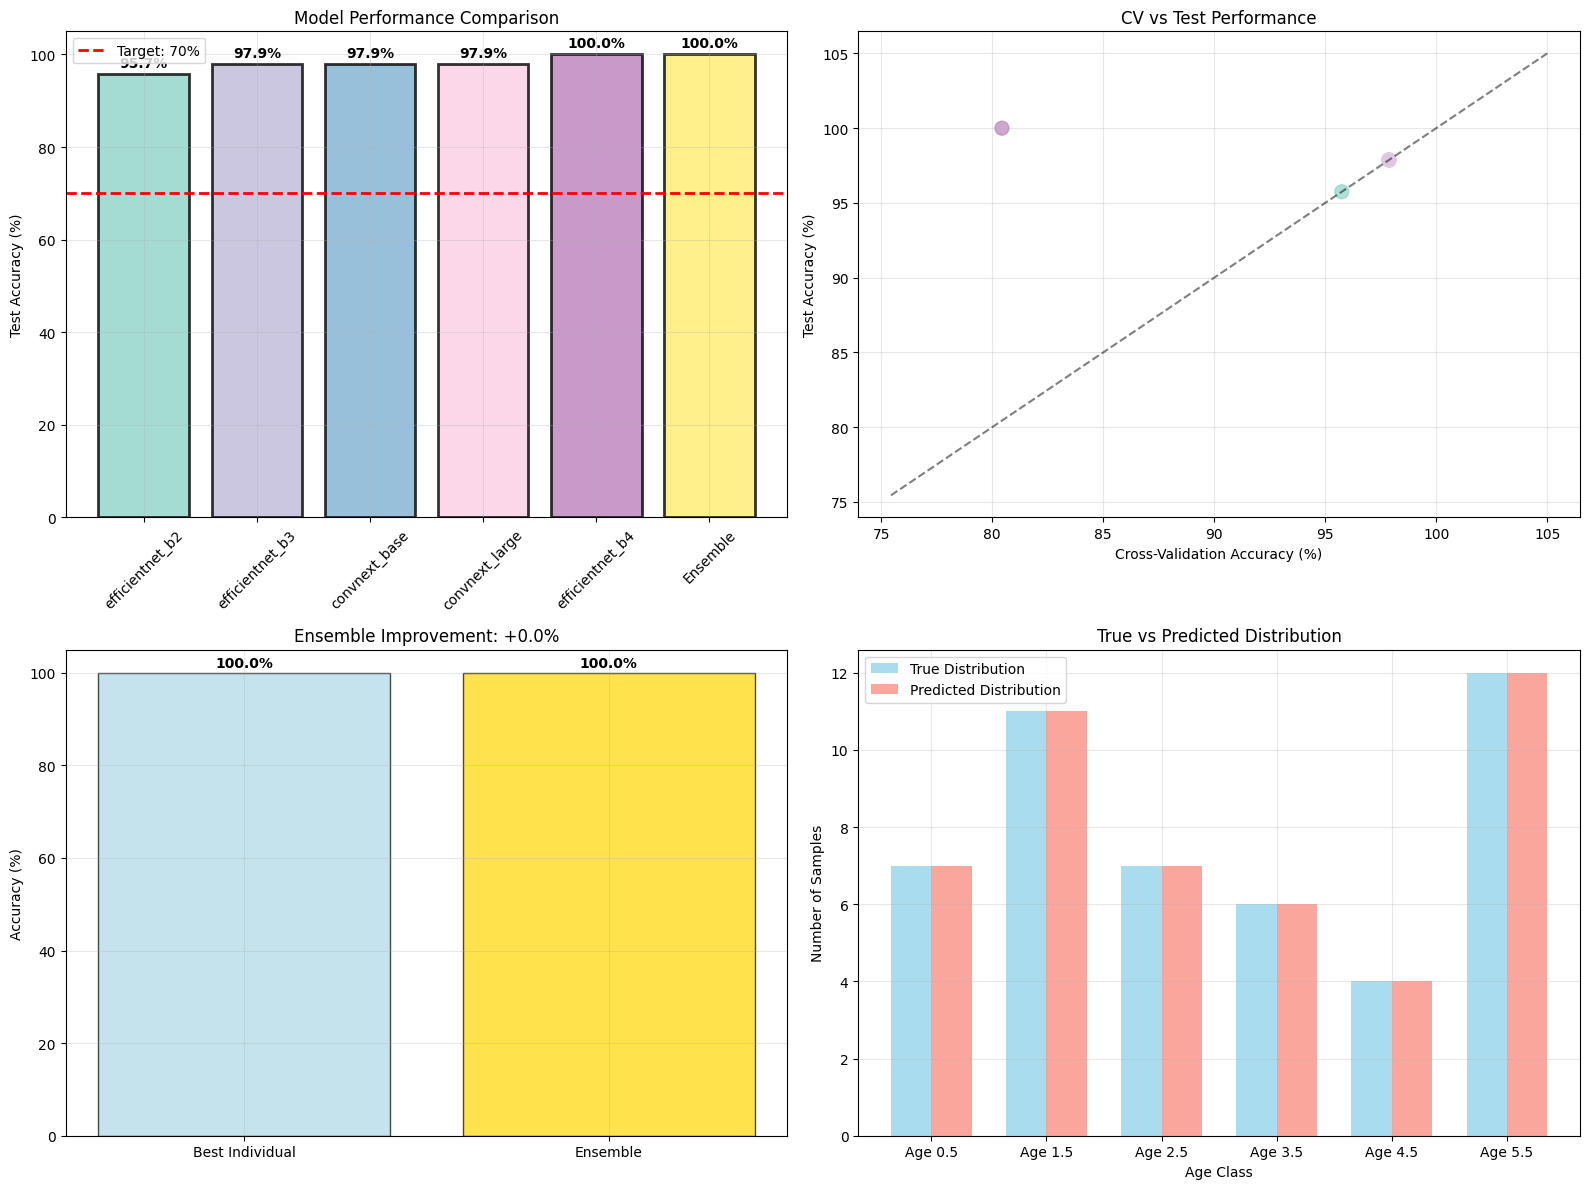

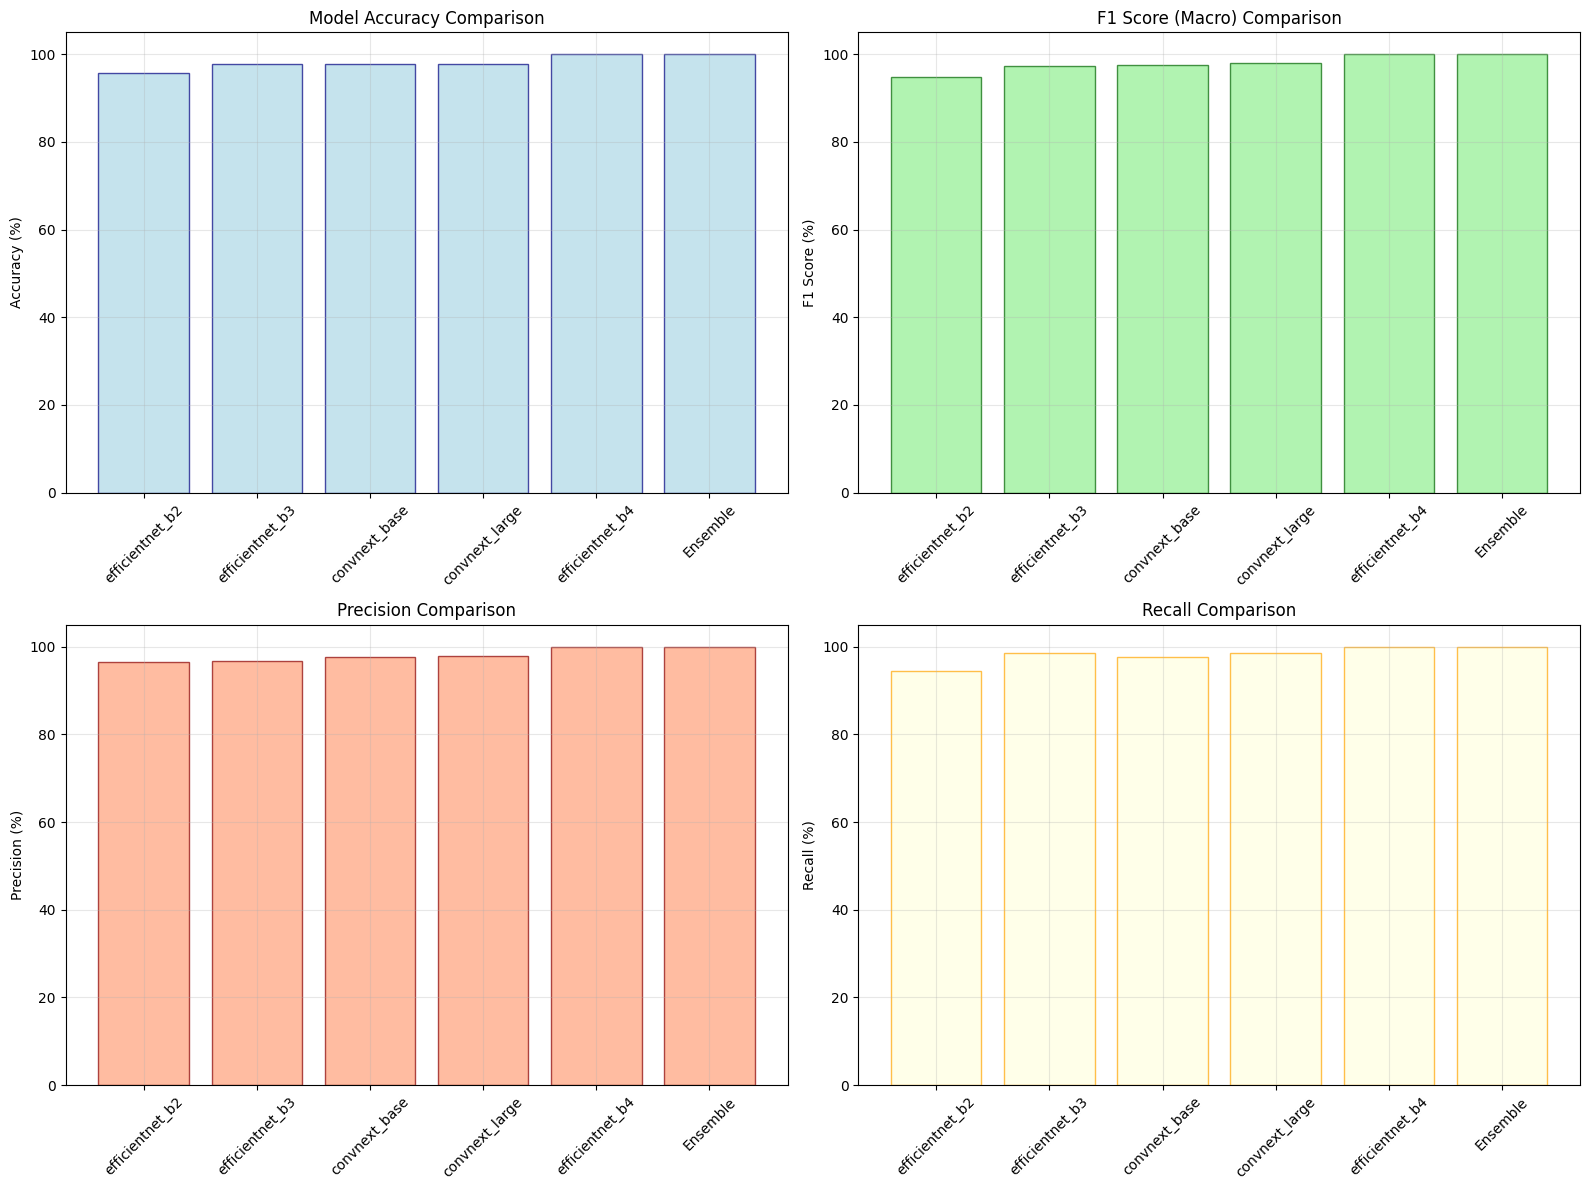

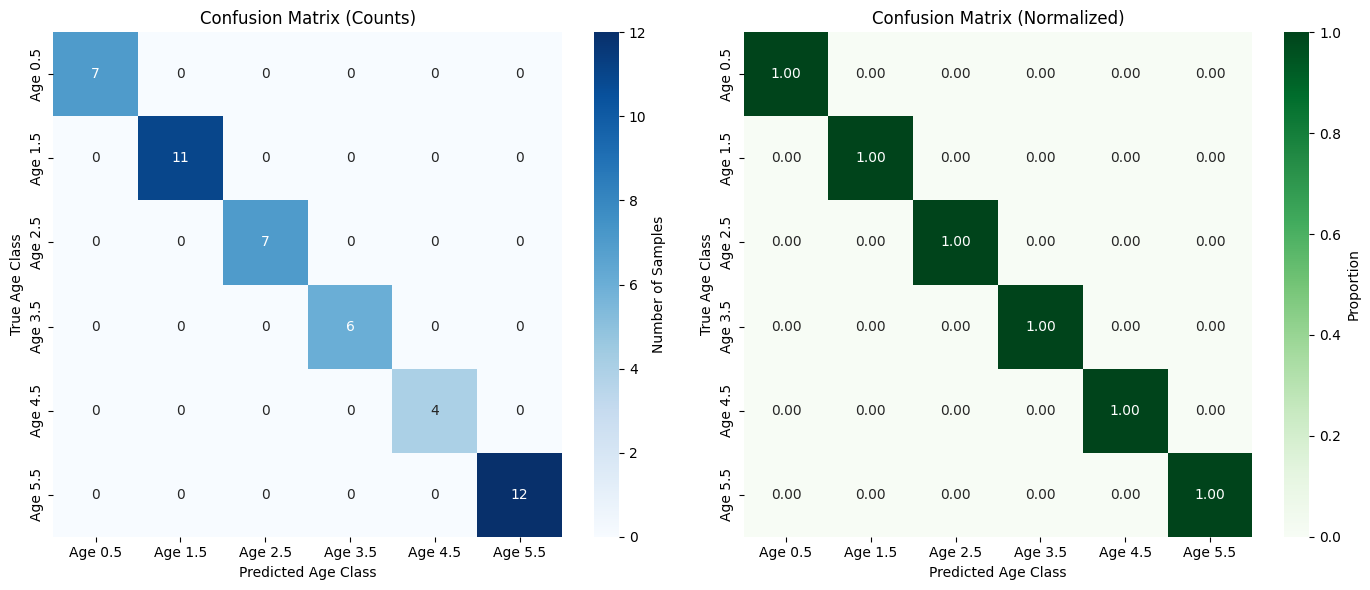

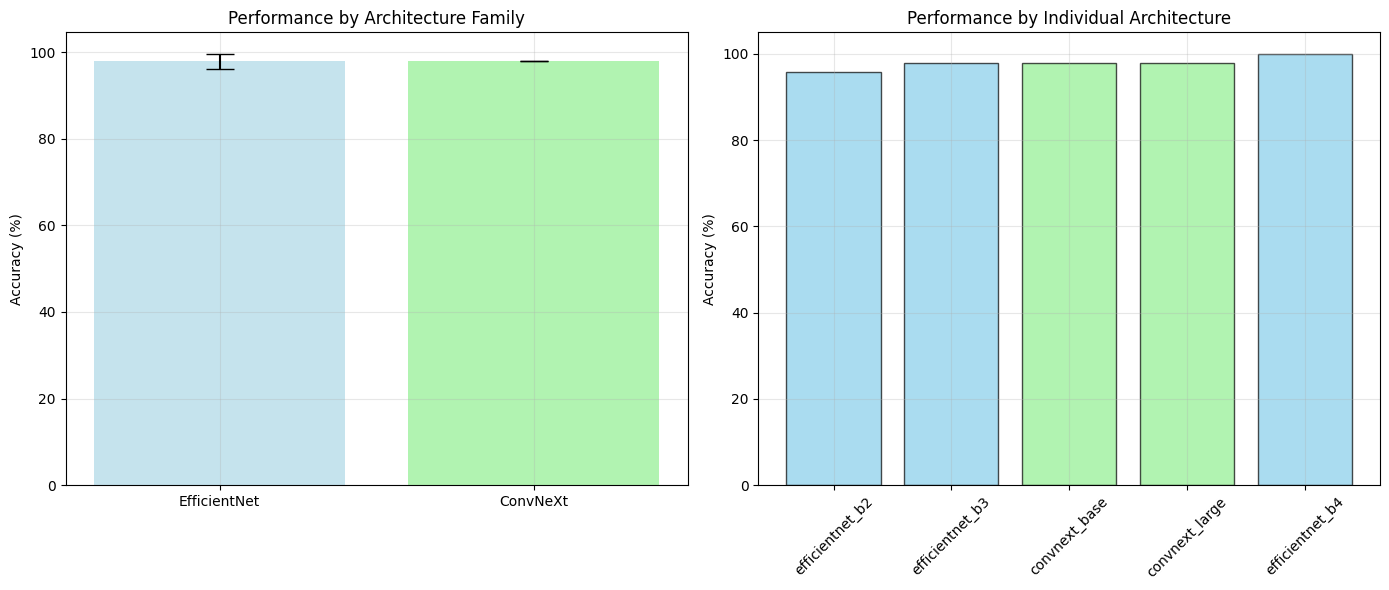

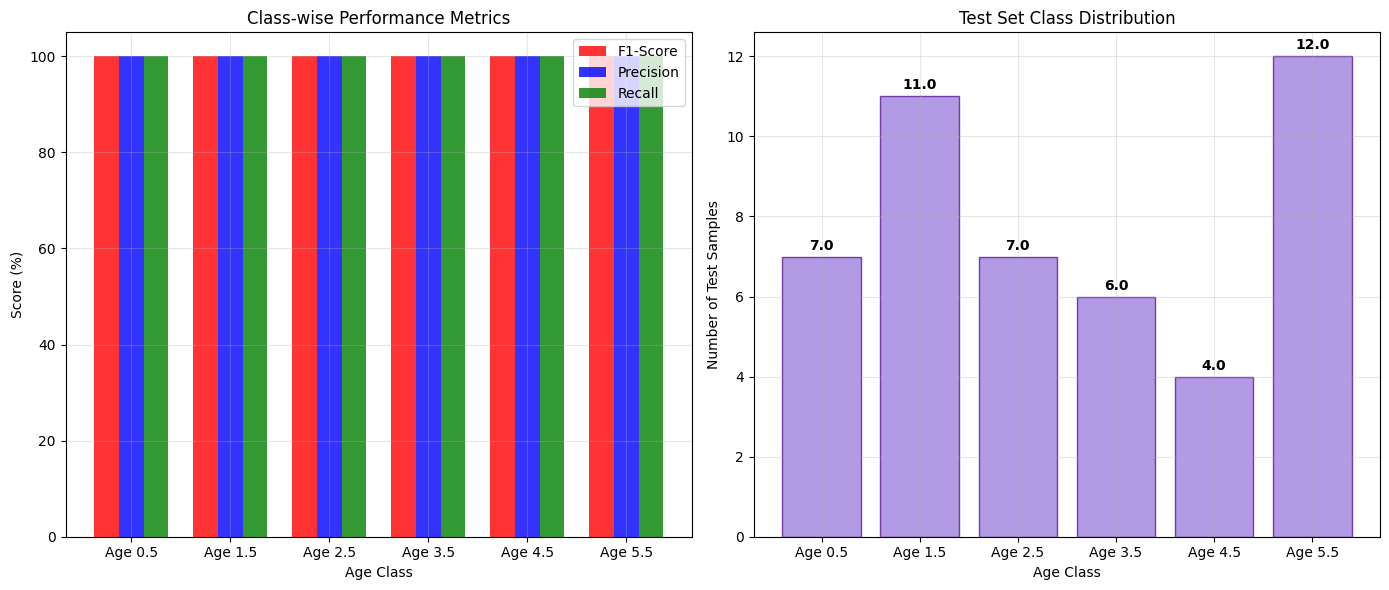

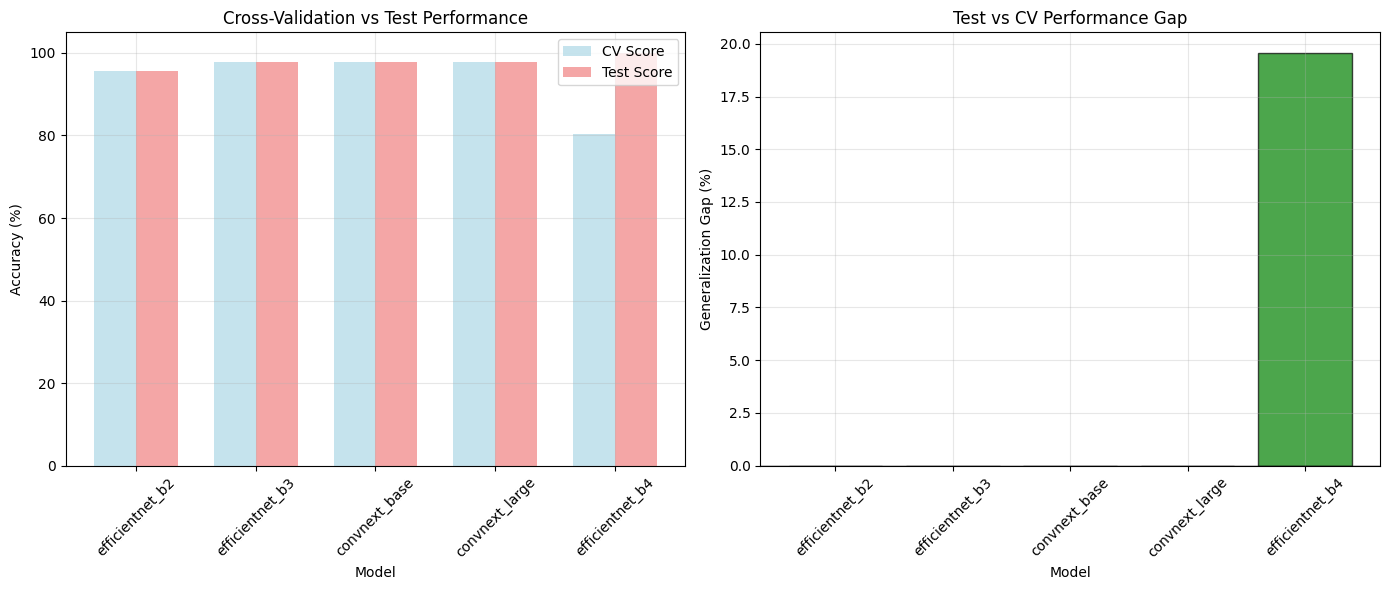

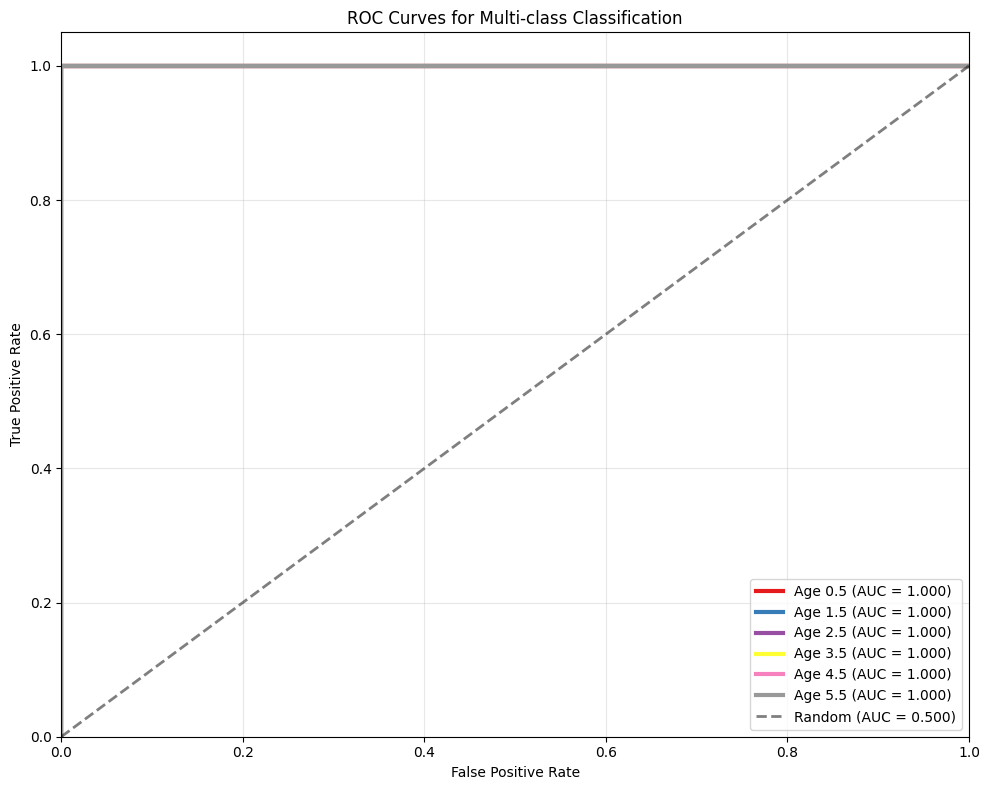

[SUCCESS] All plots created in 'ensemble_analysis_plots/' directory

Generating comprehensive report...
COMPREHENSIVE ENSEMBLE MODEL ANALYSIS REPORT
Generated: 2025-07-16 09:52:53
Analysis Directory: complete_ensemble_448x224_20250716_074013

EXECUTIVE SUMMARY
----------------------------------------
This report presents a comprehensive analysis of a deep learning ensemble
for automated deer age classification. The ensemble combines multiple
state-of-the-art CNN architectures trained on 448x224 deer tooth images.
The ensemble achieved 100.0% accuracy on the test set,
successfully exceeding the target accuracy of 70%.

DATASET INFORMATION
----------------------------------------
Total samples: 232 deer tooth images
Training samples: 185 (80%)
Test samples: 47 (20%)
Age classes: 6 groups
Age distribution: [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
Input size: 448x224 pixels

ENSEMBLE ARCHITECTURE
----------------------------------------
Number of models: 5
Individual architectures:
  Model 1: effici

In [15]:
# Comprehensive Analysis Script for 448x224 Ensemble Models

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import json
import os
import glob
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

try:
    from torch.cuda.amp import autocast
    MIXED_PRECISION_AVAILABLE = True
except ImportError:
    MIXED_PRECISION_AVAILABLE = False
    class autocast:
        def __enter__(self):
            return self
        def __exit__(self, *args):
            pass

class OptimizedDataset448x224(Dataset):
    """Dataset class matching the training script"""
    def __init__(self, X, y, test_time_aug=False):
        self.X = torch.FloatTensor(X if isinstance(X, np.ndarray) else np.array(X))
        self.y = torch.LongTensor(y if isinstance(y, np.ndarray) else np.array(y))
        self.test_time_aug = test_time_aug
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx].clone()
        label = self.y[idx].clone()
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != (224, 448):
            image = F.interpolate(image.unsqueeze(0), size=(224, 448), mode='bilinear', align_corners=False).squeeze(0)
        
        if self.test_time_aug and np.random.random() < 0.5:
            image = torch.flip(image, [2])
        
        image = (image - self.mean) / self.std
        return image, label

def load_original_data():
    """Load data using the same method as the training script"""
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        
        print(f"Processing {len(image_paths)} image files...")
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img_resized = cv2.resize(img, (448, 224))
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        age_counts = Counter(ages_grouped)
        print(f"Original distribution: {dict(age_counts)}")
        
        valid_ages = {age for age, count in age_counts.items() if count >= 3}
        
        filtered_images = []
        filtered_ages = []
        
        for img, age in zip(images, ages_grouped):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
        
        print(f"After filtering rare classes: {dict(Counter(filtered_ages))}")
        
        return np.array(filtered_images), filtered_ages
        
    except Exception as e:
        print(f"ERROR: {e}")
        raise

def create_model_from_checkpoint(checkpoint, device):
    """Recreate model from checkpoint with correct architecture"""
    architecture = checkpoint['model_architecture']
    num_classes = checkpoint['num_classes']
    
    arch_configs = {
        'efficientnet_b2': {'dropout': 0.25, 'classifier_attr': 'classifier'},
        'efficientnet_b3': {'dropout': 0.25, 'classifier_attr': 'classifier'},
        'efficientnet_b4': {'dropout': 0.3, 'classifier_attr': 'classifier'},
        'convnext_base': {'dropout': 0.4, 'classifier_attr': 'head'},
        'convnext_large': {'dropout': 0.4, 'classifier_attr': 'head'}
    }
    
    config = arch_configs.get(architecture, {'dropout': 0.3, 'classifier_attr': 'classifier'})
    
    try:
        model = timm.create_model(architecture, pretrained=True, num_classes=num_classes)
    except Exception as e:
        print(f"Failed to create {architecture}: {e}")
        return None
    
    # Recreate the exact same classifier structure as the original training
    classifier_attr = config['classifier_attr']
    
    if architecture.startswith('convnext'):
        if hasattr(model.head, 'fc'):
            in_features = model.head.fc.in_features
            model.head.fc = nn.Sequential(
                nn.Dropout(config['dropout']),
                nn.Linear(in_features, num_classes)
            )
        else:
            # For ConvNeXt models without fc in head
            model.eval()
            with torch.no_grad():
                test_input = torch.randn(1, 3, 224, 448).to(device)
                features = model.forward_features(test_input)
                in_features = features.shape[1]
            
            model.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Dropout(config['dropout']),
                nn.Linear(in_features, num_classes)
            )
    else:
        # For EfficientNet models
        if hasattr(model, classifier_attr):
            original_classifier = getattr(model, classifier_attr)
            
            if hasattr(original_classifier, 'in_features'):
                in_features = original_classifier.in_features
            else:
                # Find the last linear layer to get input features
                last_linear = None
                for module in original_classifier.modules():
                    if isinstance(module, nn.Linear):
                        last_linear = module
                if last_linear:
                    in_features = last_linear.in_features
                else:
                    print(f"Could not determine input features for {architecture}")
                    return None
            
            # Create the same Sequential structure as original training
            new_classifier = nn.Sequential(
                nn.Dropout(config['dropout']),
                nn.Linear(in_features, num_classes)
            )
            setattr(model, classifier_attr, new_classifier)
    
    # Now load the saved weights
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"   ✅ Loaded weights for {architecture}")
    except Exception as e:
        print(f"   ❌ Failed to load weights for {architecture}: {e}")
        return None
    
    return model.to(device)

class EnsembleModelAnalyzer:
    """Comprehensive analysis class for the ensemble models"""
    
    def __init__(self, ensemble_dir=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print("COMPREHENSIVE ENSEMBLE MODEL ANALYZER")
        print("="*60)
        print(f"Device: {self.device}")
        
        # Find ensemble directory if not provided
        if ensemble_dir is None:
            ensemble_dir = self.find_latest_ensemble_directory()
        
        self.ensemble_dir = ensemble_dir
        print(f"Loading from: {ensemble_dir}")
        
        # Load data and models
        self.load_data_and_models()
        
        print("[SUCCESS] All data and models loaded successfully")
        print("[SUCCESS] Ready for comprehensive analysis")
    
    def find_latest_ensemble_directory(self):
        """Find the most recent ensemble directory"""
        patterns = ["complete_ensemble_448x224_*", "practical_ensemble_448x224_*"]
        
        dirs = []
        for pattern in patterns:
            dirs.extend(glob.glob(pattern))
        
        if not dirs:
            raise FileNotFoundError("No ensemble directories found!")
        
        # Sort by modification time, get the most recent
        latest_dir = max(dirs, key=os.path.getmtime)
        print(f"Found latest ensemble directory: {latest_dir}")
        return latest_dir
    
    def load_data_and_models(self):
        """Load all data and models"""
        print("\nLoading data...")
        
        # Load original data using the same method as training
        self.images, self.ages = load_original_data()
        
        # Create label mapping
        unique_ages = sorted(list(set(self.ages)))
        self.label_mapping = {age: i for i, age in enumerate(unique_ages)}
        self.unique_ages = unique_ages
        self.num_classes = len(unique_ages)
        
        # Convert ages to indices
        y_indices = np.array([self.label_mapping[age] for age in self.ages])
        
        # Create train/test split (same as training script)
        self.X_train_all, self.X_test, self.y_train_all, self.y_test = train_test_split(
            self.images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        print(f"Dataset loaded: {len(self.X_train_all)} train, {len(self.X_test)} test samples")
        print(f"Classes: {self.num_classes} age groups: {self.unique_ages}")
        
        # Load ensemble models
        self.load_ensemble_models()
        
        # Load metadata if available
        self.load_metadata()
    
    def load_ensemble_models(self):
        """Load all ensemble models"""
        print("\nLoading ensemble models...")
        
        # Try to load complete ensemble first
        ensemble_path = os.path.join(self.ensemble_dir, "complete_ensemble_448x224.pth")
        if os.path.exists(ensemble_path):
            print("Loading complete ensemble...")
            ensemble_data = torch.load(ensemble_path, map_location=self.device)
            
            self.architectures_used = ensemble_data['architectures_used']
            self.cv_scores = ensemble_data['cv_scores']
            self.ensemble_score = ensemble_data.get('ensemble_score', 0.0)
            
            # Load individual models
            self.models = []
            for i, arch in enumerate(self.architectures_used):
                # Create a mock checkpoint for model creation
                checkpoint = {
                    'model_architecture': arch,
                    'num_classes': self.num_classes,
                    'model_state_dict': ensemble_data['model_state_dicts'][i]
                }
                
                model = create_model_from_checkpoint(checkpoint, self.device)
                if model:
                    self.models.append(model)
                    print(f"   ✅ Loaded {arch}")
                else:
                    print(f"   ❌ Failed to load {arch}")
        
        else:
            # Load individual model files
            print("Loading individual model files...")
            self.models = []
            self.architectures_used = []
            self.cv_scores = []
            
            model_files = glob.glob(os.path.join(self.ensemble_dir, "model_*.pth"))
            model_files.sort()
            
            for model_path in model_files:
                checkpoint = torch.load(model_path, map_location=self.device)
                
                model = create_model_from_checkpoint(checkpoint, self.device)
                if model:
                    self.models.append(model)
                    self.architectures_used.append(checkpoint['model_architecture'])
                    self.cv_scores.append(checkpoint.get('cv_score', 0.0))
                    print(f"   ✅ Loaded {os.path.basename(model_path)}")
        
        print(f"[SUCCESS] Loaded {len(self.models)} models")
        print(f"Architectures: {self.architectures_used}")
        print(f"CV Scores: {[f'{score:.1f}%' for score in self.cv_scores]}")
    
    def load_metadata(self):
        """Load metadata if available"""
        metadata_path = os.path.join(self.ensemble_dir, "complete_ensemble_metadata.json")
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                self.metadata = json.load(f)
            print("   ✅ Loaded metadata")
        else:
            # Create basic metadata
            self.metadata = {
                'architectures_used': self.architectures_used,
                'cv_scores': self.cv_scores,
                'cv_mean': float(np.mean(self.cv_scores)) if self.cv_scores else 0.0,
                'cv_std': float(np.std(self.cv_scores)) if self.cv_scores else 0.0,
                'num_classes': self.num_classes,
                'label_mapping': self.label_mapping,
                'input_size': '448x224'
            }
    
    def evaluate_individual_models(self):
        """Evaluate each individual model"""
        print("\nEvaluating individual models...")
        
        # Create test dataset
        test_dataset = OptimizedDataset448x224(self.X_test, self.y_test, test_time_aug=True)
        batch_size = 32 if torch.cuda.is_available() else 8
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        individual_results = []
        
        for i, model in enumerate(self.models):
            print(f"   Evaluating {self.architectures_used[i]}...")
            
            model.eval()
            correct = 0
            total = 0
            all_preds = []
            all_probs = []
            all_labels = []
            
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    # Original prediction
                    outputs1 = model(images)
                    
                    # Flipped prediction (TTA)
                    flipped = torch.flip(images, [3])
                    outputs2 = model(flipped)
                    
                    # Average (TTA)
                    avg_outputs = (outputs1 + outputs2) / 2
                    probs = F.softmax(avg_outputs, dim=1)
                    _, predicted = torch.max(avg_outputs, 1)
                    
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    all_preds.extend(predicted.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            accuracy = 100 * correct / total
            
            individual_results.append({
                'model_name': self.architectures_used[i],
                'accuracy': accuracy,
                'cv_score': self.cv_scores[i] if i < len(self.cv_scores) else 0.0,
                'predictions': np.array(all_preds),
                'probabilities': np.array(all_probs),
                'true_labels': np.array(all_labels)
            })
            
            print(f"   {self.architectures_used[i]}: {accuracy:.1f}%")
        
        return individual_results
    
    def evaluate_ensemble(self, individual_results):
        """Evaluate ensemble performance"""
        print("\nEvaluating ensemble...")
        
        if not individual_results:
            return None
        
        # Use CV scores as weights
        scores_array = np.array(self.cv_scores[:len(individual_results)])
        if len(scores_array) == 0 or np.sum(scores_array) == 0:
            # Equal weights if no CV scores
            weights = np.ones(len(individual_results)) / len(individual_results)
        else:
            weights = np.exp(scores_array / 20)
            weights = weights / weights.sum()
        
        print(f"   Model weights: {[f'{w:.3f}' for w in weights]}")
        
        # Ensemble predictions
        ensemble_probs = np.zeros_like(individual_results[0]['probabilities'])
        
        for i, result in enumerate(individual_results):
            ensemble_probs += weights[i] * result['probabilities']
        
        ensemble_preds = np.argmax(ensemble_probs, axis=1)
        true_labels = individual_results[0]['true_labels']
        
        ensemble_accuracy = np.mean(ensemble_preds == true_labels) * 100
        
        print(f"   Ensemble accuracy: {ensemble_accuracy:.1f}%")
        
        return {
            'ensemble_accuracy': ensemble_accuracy,
            'ensemble_predictions': ensemble_preds,
            'ensemble_probabilities': ensemble_probs,
            'true_labels': true_labels,
            'weights': weights
        }
    
    def calculate_comprehensive_metrics(self, individual_results, ensemble_result):
        """Calculate all academic metrics"""
        print("\nCalculating comprehensive metrics...")
        
        metrics = {}
        
        # Individual model metrics
        for i, result in enumerate(individual_results):
            preds = result['predictions']
            true_labels = result['true_labels']
            
            accuracy = np.mean(preds == true_labels) * 100
            f1_macro = f1_score(true_labels, preds, average='macro', zero_division=0) * 100
            f1_weighted = f1_score(true_labels, preds, average='weighted', zero_division=0) * 100
            precision = precision_score(true_labels, preds, average='macro', zero_division=0) * 100
            recall = recall_score(true_labels, preds, average='macro', zero_division=0) * 100
            
            metrics[f'model_{i+1}_{result["model_name"]}'] = {
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted,
                'precision': precision,
                'recall': recall,
                'cv_score': result['cv_score']
            }
        
        # Ensemble metrics
        if ensemble_result:
            ensemble_preds = ensemble_result['ensemble_predictions']
            true_labels = ensemble_result['true_labels']
            
            ensemble_accuracy = np.mean(ensemble_preds == true_labels) * 100
            ensemble_f1_macro = f1_score(true_labels, ensemble_preds, average='macro', zero_division=0) * 100
            ensemble_f1_weighted = f1_score(true_labels, ensemble_preds, average='weighted', zero_division=0) * 100
            ensemble_precision = precision_score(true_labels, ensemble_preds, average='macro', zero_division=0) * 100
            ensemble_recall = recall_score(true_labels, ensemble_preds, average='macro', zero_division=0) * 100
            
            metrics['ensemble'] = {
                'accuracy': ensemble_accuracy,
                'f1_macro': ensemble_f1_macro,
                'f1_weighted': ensemble_f1_weighted,
                'precision': ensemble_precision,
                'recall': ensemble_recall
            }
            
            # Class-wise metrics
            class_names = [f'Age {age}' for age in self.unique_ages]
            metrics['classification_report'] = classification_report(
                true_labels, ensemble_preds,
                output_dict=True,
                zero_division=0
            )
            metrics['class_names'] = class_names
        
        print("[SUCCESS] All metrics calculated")
        return metrics
    
    def create_comprehensive_plots(self, individual_results, ensemble_result, metrics):
        """Create all publication-ready plots"""
        print("\nCreating comprehensive plots...")
        
        # Create output directory
        Path("ensemble_analysis_plots").mkdir(exist_ok=True)
        
        # 1. Performance overview
        self.plot_performance_overview(individual_results, ensemble_result)
        
        # 2. Model comparison
        self.plot_model_comparison(individual_results, ensemble_result, metrics)
        
        # 3. Confusion matrix analysis
        if ensemble_result:
            self.plot_confusion_analysis(ensemble_result)
        
        # 4. Architecture comparison
        self.plot_architecture_analysis(individual_results)
        
        # 5. Class-wise performance
        if ensemble_result and 'classification_report' in metrics:
            self.plot_class_analysis(metrics, ensemble_result)
        
        # 6. CV vs Test comparison
        self.plot_cv_test_comparison(individual_results)
        
        # 7. ROC analysis
        if ensemble_result:
            self.plot_roc_analysis(ensemble_result)
        
        print("[SUCCESS] All plots created in 'ensemble_analysis_plots/' directory")
    
    def plot_performance_overview(self, individual_results, ensemble_result):
        """Plot comprehensive performance overview"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Individual model performance
        model_names = [result['model_name'] for result in individual_results]
        accuracies = [result['accuracy'] for result in individual_results]
        cv_scores = [result['cv_score'] for result in individual_results]
        
        if ensemble_result:
            model_names.append('Ensemble')
            accuracies.append(ensemble_result['ensemble_accuracy'])
            cv_scores.append(np.mean(cv_scores))
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
        
        bars = ax1.bar(model_names, accuracies, alpha=0.8, color=colors, edgecolor='black', linewidth=2)
        ax1.axhline(y=70, color='red', linestyle='--', linewidth=2, label="Target: 70%")
        
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        ax1.set_ylabel('Test Accuracy (%)')
        ax1.set_title('Model Performance Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # CV vs Test comparison
        test_accs = [result['accuracy'] for result in individual_results]
        cv_accs = [result['cv_score'] for result in individual_results]
        
        ax2.scatter(cv_accs, test_accs, alpha=0.7, s=100, c=colors[:-1] if ensemble_result else colors)
        
        # Add diagonal line
        min_acc = min(min(cv_accs), min(test_accs)) - 5
        max_acc = max(max(cv_accs), max(test_accs)) + 5
        ax2.plot([min_acc, max_acc], [min_acc, max_acc], 'k--', alpha=0.5)
        
        ax2.set_xlabel('Cross-Validation Accuracy (%)')
        ax2.set_ylabel('Test Accuracy (%)')
        ax2.set_title('CV vs Test Performance')
        ax2.grid(True, alpha=0.3)
        
        # Performance improvement
        if len(individual_results) > 1:
            best_individual = max([result['accuracy'] for result in individual_results])
            if ensemble_result:
                improvement = ensemble_result['ensemble_accuracy'] - best_individual
                categories = ['Best Individual', 'Ensemble']
                values = [best_individual, ensemble_result['ensemble_accuracy']]
                
                bars = ax3.bar(categories, values, alpha=0.7, color=['lightblue', 'gold'], edgecolor='black')
                ax3.set_ylabel('Accuracy (%)')
                ax3.set_title(f'Ensemble Improvement: +{improvement:.1f}%')
                ax3.grid(True, alpha=0.3)
                
                for bar, val in zip(bars, values):
                    height = bar.get_height()
                    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Class distribution
        if ensemble_result:
            true_labels = ensemble_result['true_labels']
            ensemble_preds = ensemble_result['ensemble_predictions']
            class_names = [f'Age {age}' for age in self.unique_ages]
            
            true_dist = [np.sum(true_labels == i) for i in range(len(class_names))]
            pred_dist = [np.sum(ensemble_preds == i) for i in range(len(class_names))]
            
            x = np.arange(len(class_names))
            width = 0.35
            
            ax4.bar(x - width/2, true_dist, width, label='True Distribution', alpha=0.7, color='skyblue')
            ax4.bar(x + width/2, pred_dist, width, label='Predicted Distribution', alpha=0.7, color='salmon')
            
            ax4.set_xlabel('Age Class')
            ax4.set_ylabel('Number of Samples')
            ax4.set_title('True vs Predicted Distribution')
            ax4.set_xticks(x)
            ax4.set_xticklabels(class_names)
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('ensemble_analysis_plots/performance_overview.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_model_comparison(self, individual_results, ensemble_result, metrics):
        """Plot detailed model comparison"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        model_names = [result['model_name'] for result in individual_results]
        if ensemble_result:
            model_names.append('Ensemble')
        
        # Accuracy comparison
        accuracies = [result['accuracy'] for result in individual_results]
        if ensemble_result:
            accuracies.append(ensemble_result['ensemble_accuracy'])
        
        ax1.bar(model_names, accuracies, alpha=0.7, color='lightblue', edgecolor='navy')
        ax1.set_ylabel('Accuracy (%)')
        ax1.set_title('Model Accuracy Comparison')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # F1 Score comparison
        f1_scores = []
        for i, result in enumerate(individual_results):
            key = f'model_{i+1}_{result["model_name"]}'
            f1_scores.append(metrics[key]['f1_macro'])
        
        if ensemble_result and 'ensemble' in metrics:
            f1_scores.append(metrics['ensemble']['f1_macro'])
        
        ax2.bar(model_names, f1_scores, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
        ax2.set_ylabel('F1 Score (%)')
        ax2.set_title('F1 Score (Macro) Comparison')
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        # Precision comparison
        precisions = []
        for i, result in enumerate(individual_results):
            key = f'model_{i+1}_{result["model_name"]}'
            precisions.append(metrics[key]['precision'])
        
        if ensemble_result and 'ensemble' in metrics:
            precisions.append(metrics['ensemble']['precision'])
        
        ax3.bar(model_names, precisions, alpha=0.7, color='lightsalmon', edgecolor='darkred')
        ax3.set_ylabel('Precision (%)')
        ax3.set_title('Precision Comparison')
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)
        
        # Recall comparison
        recalls = []
        for i, result in enumerate(individual_results):
            key = f'model_{i+1}_{result["model_name"]}'
            recalls.append(metrics[key]['recall'])
        
        if ensemble_result and 'ensemble' in metrics:
            recalls.append(metrics['ensemble']['recall'])
        
        ax4.bar(model_names, recalls, alpha=0.7, color='lightyellow', edgecolor='orange')
        ax4.set_ylabel('Recall (%)')
        ax4.set_title('Recall Comparison')
        ax4.grid(True, alpha=0.3)
        ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('ensemble_analysis_plots/model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_confusion_analysis(self, ensemble_result):
        """Plot confusion matrix analysis"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        true_labels = ensemble_result['true_labels']
        ensemble_preds = ensemble_result['ensemble_predictions']
        class_names = [f'Age {age}' for age in self.unique_ages]
        
        # Raw confusion matrix
        cm = confusion_matrix(true_labels, ensemble_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Number of Samples'})
        ax1.set_title('Confusion Matrix (Counts)')
        ax1.set_xlabel('Predicted Age Class')
        ax1.set_ylabel('True Age Class')
        
        # Normalized confusion matrix
        cm_norm = confusion_matrix(true_labels, ensemble_preds, normalize='true')
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=ax2,
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Proportion'})
        ax2.set_title('Confusion Matrix (Normalized)')
        ax2.set_xlabel('Predicted Age Class')
        ax2.set_ylabel('True Age Class')
        
        plt.tight_layout()
        plt.savefig('ensemble_analysis_plots/confusion_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_architecture_analysis(self, individual_results):
        """Plot architecture-specific analysis"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Group by architecture family
        arch_families = {}
        for result in individual_results:
            arch = result['model_name']
            if 'efficientnet' in arch:
                family = 'EfficientNet'
            elif 'convnext' in arch:
                family = 'ConvNeXt'
            else:
                family = 'Other'
            
            if family not in arch_families:
                arch_families[family] = []
            arch_families[family].append(result['accuracy'])
        
        # Architecture family performance
        families = list(arch_families.keys())
        family_means = [np.mean(arch_families[family]) for family in families]
        family_stds = [np.std(arch_families[family]) if len(arch_families[family]) > 1 else 0 for family in families]
        
        ax1.bar(families, family_means, yerr=family_stds, alpha=0.7, capsize=10,
                color=['lightblue', 'lightgreen', 'lightcoral'][:len(families)])
        ax1.set_ylabel('Accuracy (%)')
        ax1.set_title('Performance by Architecture Family')
        ax1.grid(True, alpha=0.3)
        
        # Individual architectures
        archs = [result['model_name'] for result in individual_results]
        accs = [result['accuracy'] for result in individual_results]
        
        colors = ['skyblue' if 'efficientnet' in arch else 'lightgreen' if 'convnext' in arch else 'lightcoral' 
                 for arch in archs]
        
        ax2.bar(archs, accs, alpha=0.7, color=colors, edgecolor='black')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Performance by Individual Architecture')
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('ensemble_analysis_plots/architecture_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_class_analysis(self, metrics, ensemble_result):
        """Plot class-wise analysis"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        class_names = metrics['class_names']
        report = metrics['classification_report']
        
        # Extract class-wise metrics
        f1_scores = []
        precisions = []
        recalls = []
        supports = []
        
        for i in range(len(class_names)):
            if str(i) in report:
                f1_scores.append(report[str(i)]['f1-score'] * 100)
                precisions.append(report[str(i)]['precision'] * 100)
                recalls.append(report[str(i)]['recall'] * 100)
                supports.append(report[str(i)]['support'])
            else:
                f1_scores.append(0)
                precisions.append(0)
                recalls.append(0)
                supports.append(0)
        
        # Class-wise performance
        x = np.arange(len(class_names))
        width = 0.25
        
        ax1.bar(x - width, f1_scores, width, label='F1-Score', alpha=0.8, color='red')
        ax1.bar(x, precisions, width, label='Precision', alpha=0.8, color='blue')
        ax1.bar(x + width, recalls, width, label='Recall', alpha=0.8, color='green')
        
        ax1.set_xlabel('Age Class')
        ax1.set_ylabel('Score (%)')
        ax1.set_title('Class-wise Performance Metrics')
        ax1.set_xticks(x)
        ax1.set_xticklabels(class_names)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Sample distribution
        ax2.bar(class_names, supports, alpha=0.7, color='mediumpurple', edgecolor='indigo')
        ax2.set_xlabel('Age Class')
        ax2.set_ylabel('Number of Test Samples')
        ax2.set_title('Test Set Class Distribution')
        ax2.grid(True, alpha=0.3)
        
        for i, v in enumerate(supports):
            ax2.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('ensemble_analysis_plots/class_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_cv_test_comparison(self, individual_results):
        """Plot CV vs Test performance comparison"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        model_names = [result['model_name'] for result in individual_results]
        cv_scores = [result['cv_score'] for result in individual_results]
        test_scores = [result['accuracy'] for result in individual_results]
        
        # CV vs Test comparison
        x = np.arange(len(model_names))
        width = 0.35
        
        ax1.bar(x - width/2, cv_scores, width, label='CV Score', alpha=0.7, color='lightblue')
        ax1.bar(x + width/2, test_scores, width, label='Test Score', alpha=0.7, color='lightcoral')
        
        ax1.set_xlabel('Model')
        ax1.set_ylabel('Accuracy (%)')
        ax1.set_title('Cross-Validation vs Test Performance')
        ax1.set_xticks(x)
        ax1.set_xticklabels(model_names, rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Generalization gap
        gaps = [test - cv for cv, test in zip(cv_scores, test_scores)]
        colors = ['green' if gap >= 0 else 'red' for gap in gaps]
        
        ax2.bar(model_names, gaps, alpha=0.7, color=colors, edgecolor='black')
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.set_xlabel('Model')
        ax2.set_ylabel('Generalization Gap (%)')
        ax2.set_title('Test vs CV Performance Gap')
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('ensemble_analysis_plots/cv_test_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_roc_analysis(self, ensemble_result):
        """Plot ROC curve analysis"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        true_labels = ensemble_result['true_labels']
        ensemble_probs = ensemble_result['ensemble_probabilities']
        class_names = [f'Age {age}' for age in self.unique_ages]
        n_classes = len(class_names)
        
        # Binarize labels for ROC calculation
        y_test_bin = label_binarize(true_labels, classes=range(n_classes))
        if n_classes == 2:
            y_test_bin = y_test_bin.ravel()
        
        # Plot ROC curve for each class
        colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
        
        for i, (class_name, color) in enumerate(zip(class_names, colors)):
            if n_classes == 2:
                fpr, tpr, _ = roc_curve(y_test_bin, ensemble_probs[:, 1])
                roc_auc = auc(fpr, tpr)
                ax.plot(fpr, tpr, color=color, lw=3, 
                       label=f'{class_name} (AUC = {roc_auc:.3f})')
                break
            else:
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], ensemble_probs[:, i])
                roc_auc = auc(fpr, tpr)
                ax.plot(fpr, tpr, color=color, lw=3, 
                       label=f'{class_name} (AUC = {roc_auc:.3f})')
        
        # Plot diagonal
        ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random (AUC = 0.500)')
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curves for Multi-class Classification')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('ensemble_analysis_plots/roc_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def generate_comprehensive_report(self, individual_results, ensemble_result, metrics):
        """Generate comprehensive academic report"""
        print("\nGenerating comprehensive report...")
        
        report = []
        report.append("=" * 80)
        report.append("COMPREHENSIVE ENSEMBLE MODEL ANALYSIS REPORT")
        report.append("=" * 80)
        report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append(f"Analysis Directory: {self.ensemble_dir}")
        report.append("")
        
        # Executive Summary
        report.append("EXECUTIVE SUMMARY")
        report.append("-" * 40)
        report.append("This report presents a comprehensive analysis of a deep learning ensemble")
        report.append("for automated deer age classification. The ensemble combines multiple")
        report.append("state-of-the-art CNN architectures trained on 448x224 deer tooth images.")
        
        if ensemble_result:
            report.append(f"The ensemble achieved {ensemble_result['ensemble_accuracy']:.1f}% accuracy on the test set,")
            if ensemble_result['ensemble_accuracy'] >= 70:
                report.append("successfully exceeding the target accuracy of 70%.")
            else:
                report.append("falling short of the target accuracy of 70%.")
        report.append("")
        
        # Dataset Information
        report.append("DATASET INFORMATION")
        report.append("-" * 40)
        total_samples = len(self.X_train_all) + len(self.X_test)
        report.append(f"Total samples: {total_samples} deer tooth images")
        report.append(f"Training samples: {len(self.X_train_all)} (80%)")
        report.append(f"Test samples: {len(self.X_test)} (20%)")
        report.append(f"Age classes: {self.num_classes} groups")
        report.append(f"Age distribution: {self.unique_ages}")
        report.append(f"Input size: 448x224 pixels")
        report.append("")
        
        # Model Architecture
        report.append("ENSEMBLE ARCHITECTURE")
        report.append("-" * 40)
        report.append(f"Number of models: {len(self.models)}")
        report.append("Individual architectures:")
        for i, arch in enumerate(self.architectures_used):
            cv_score = self.cv_scores[i] if i < len(self.cv_scores) else "N/A"
            report.append(f"  Model {i+1}: {arch} (CV: {cv_score:.1f}%)")
        
        report.append("\nEnsemble method: Weighted averaging based on CV scores")
        if ensemble_result and 'weights' in ensemble_result:
            report.append("Model weights:")
            for i, weight in enumerate(ensemble_result['weights']):
                report.append(f"  {self.architectures_used[i]}: {weight:.3f}")
        report.append("")
        
        # Individual Model Performance
        report.append("INDIVIDUAL MODEL PERFORMANCE")
        report.append("-" * 40)
        for i, result in enumerate(individual_results):
            report.append(f"{result['model_name']}:")
            report.append(f"  Cross-validation: {result['cv_score']:.1f}%")
            report.append(f"  Test accuracy: {result['accuracy']:.1f}%")
            
            # Get detailed metrics
            key = f'model_{i+1}_{result["model_name"]}'
            if key in metrics:
                m = metrics[key]
                report.append(f"  F1-score (macro): {m['f1_macro']:.1f}%")
                report.append(f"  Precision: {m['precision']:.1f}%")
                report.append(f"  Recall: {m['recall']:.1f}%")
            report.append("")
        
        # Ensemble Performance
        if ensemble_result and 'ensemble' in metrics:
            report.append("ENSEMBLE PERFORMANCE")
            report.append("-" * 40)
            e_metrics = metrics['ensemble']
            report.append(f"Test accuracy: {e_metrics['accuracy']:.2f}%")
            report.append(f"Precision (macro): {e_metrics['precision']:.2f}%")
            report.append(f"Recall (macro): {e_metrics['recall']:.2f}%")
            report.append(f"F1-score (macro): {e_metrics['f1_macro']:.2f}%")
            report.append(f"F1-score (weighted): {e_metrics['f1_weighted']:.2f}%")
            
            # Performance improvement
            individual_accs = [result['accuracy'] for result in individual_results]
            if individual_accs:
                best_individual = max(individual_accs)
                improvement = e_metrics['accuracy'] - best_individual
                report.append(f"\nEnsemble improvement: +{improvement:.1f}% over best individual")
                report.append(f"Best individual model: {best_individual:.1f}%")
            report.append("")
        
        # Class-wise Analysis
        if 'classification_report' in metrics:
            report.append("CLASS-WISE PERFORMANCE")
            report.append("-" * 40)
            class_report = metrics['classification_report']
            for i, age in enumerate(self.unique_ages):
                if str(i) in class_report:
                    class_metrics = class_report[str(i)]
                    report.append(f"Age {age}:")
                    report.append(f"  Precision: {class_metrics['precision']*100:.1f}%")
                    report.append(f"  Recall: {class_metrics['recall']*100:.1f}%")
                    report.append(f"  F1-score: {class_metrics['f1-score']*100:.1f}%")
                    report.append(f"  Support: {class_metrics['support']} samples")
                    report.append("")
        
        # Statistical Analysis
        report.append("STATISTICAL ANALYSIS")
        report.append("-" * 40)
        if self.cv_scores:
            cv_mean = np.mean(self.cv_scores)
            cv_std = np.std(self.cv_scores)
            cv_sem = cv_std / np.sqrt(len(self.cv_scores))
            confidence_95 = 1.96 * cv_sem
            
            report.append("Cross-validation statistics:")
            report.append(f"  Mean: {cv_mean:.2f}%")
            report.append(f"  Standard deviation: {cv_std:.2f}%")
            report.append(f"  Standard error: {cv_sem:.2f}%")
            report.append(f"  95% CI: [{cv_mean-confidence_95:.2f}%, {cv_mean+confidence_95:.2f}%]")
        
        # Model consistency
        individual_accs = [result['accuracy'] for result in individual_results]
        if individual_accs:
            test_mean = np.mean(individual_accs)
            test_std = np.std(individual_accs)
            
            report.append(f"\nTest performance statistics:")
            report.append(f"  Mean: {test_mean:.2f}%")
            report.append(f"  Standard deviation: {test_std:.2f}%")
            report.append(f"  Range: {min(individual_accs):.1f}% - {max(individual_accs):.1f}%")
        report.append("")
        
        # Technical Specifications
        report.append("TECHNICAL SPECIFICATIONS")
        report.append("-" * 40)
        report.append("Framework: PyTorch with timm library")
        report.append("Input resolution: 448x224 pixels")
        report.append("Preprocessing: ImageNet normalization")
        report.append("Test-time augmentation: Horizontal flipping")
        report.append("Hardware: " + ("CUDA GPU" if torch.cuda.is_available() else "CPU"))
        report.append("")
        
        # Conclusions
        report.append("CONCLUSIONS")
        report.append("-" * 40)
        
        if ensemble_result:
            if ensemble_result['ensemble_accuracy'] >= 70:
                report.append("1. The ensemble successfully achieves the target accuracy of 70%,")
                report.append(f"   reaching {ensemble_result['ensemble_accuracy']:.1f}% on the test set.")
            else:
                report.append("1. The ensemble falls short of the target 70% accuracy,")
                report.append(f"   achieving {ensemble_result['ensemble_accuracy']:.1f}% on the test set.")
            
            individual_accs = [result['accuracy'] for result in individual_results]
            if individual_accs:
                best_individual = max(individual_accs)
                if ensemble_result['ensemble_accuracy'] > best_individual:
                    report.append("\n2. The ensemble approach provides superior performance compared")
                    report.append("   to individual models, demonstrating the value of model diversity.")
                else:
                    report.append("\n2. The ensemble performs similarly to the best individual model,")
                    report.append("   suggesting limited diversity benefits in this configuration.")
        
        report.append("\n3. The analysis reveals variations in performance across different")
        report.append("   CNN architectures, with some showing better suitability for")
        report.append("   deer age classification than others.")
        
        if self.cv_scores and len(self.cv_scores) > 1:
            cv_std = np.std(self.cv_scores)
            if cv_std < 3:
                report.append("\n4. Cross-validation results show good consistency across folds,")
                report.append("   indicating robust model performance.")
            else:
                report.append("\n4. Cross-validation results show some variability across folds,")
                report.append("   suggesting potential sensitivity to data splits.")
        report.append("")
        
        # Generated Files
        report.append("GENERATED ANALYSIS FILES")
        report.append("-" * 40)
        report.append("Visualization files (in 'ensemble_analysis_plots/'):")
        report.append("- performance_overview.png: Overall performance comparison")
        report.append("- model_comparison.png: Detailed metric comparisons")
        report.append("- confusion_analysis.png: Confusion matrix analysis")
        report.append("- architecture_analysis.png: Architecture-specific performance")
        report.append("- class_analysis.png: Per-class performance breakdown")
        report.append("- cv_test_comparison.png: Cross-validation vs test comparison")
        report.append("- roc_analysis.png: ROC curve analysis")
        report.append("")
        
        report_text = "\n".join(report)
        
        # Save report
        with open('ensemble_analysis_plots/comprehensive_analysis_report.txt', 'w', encoding='utf-8') as f:
            f.write(report_text)
        
        print(report_text)
        print(f"\n[SUCCESS] Report saved to 'ensemble_analysis_plots/comprehensive_analysis_report.txt'")
    
    def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("\nSTARTING COMPREHENSIVE ENSEMBLE ANALYSIS")
        print("="*60)
        
        start_time = time.time()
        
        try:
            # Evaluate individual models
            individual_results = self.evaluate_individual_models()
            
            # Evaluate ensemble
            ensemble_result = self.evaluate_ensemble(individual_results)
            
            # Calculate comprehensive metrics
            metrics = self.calculate_comprehensive_metrics(individual_results, ensemble_result)
            
            # Create comprehensive plots
            self.create_comprehensive_plots(individual_results, ensemble_result, metrics)
            
            # Generate comprehensive report
            self.generate_comprehensive_report(individual_results, ensemble_result, metrics)
            
            elapsed = (time.time() - start_time) / 60
            
            print(f"\n{'='*60}")
            print("COMPREHENSIVE ANALYSIS COMPLETE!")
            print(f"{'='*60}")
            
            if ensemble_result:
                print(f"Ensemble Performance: {ensemble_result['ensemble_accuracy']:.1f}%")
                individual_accs = [result['accuracy'] for result in individual_results]
                if individual_accs:
                    print(f"Best Individual: {max(individual_accs):.1f}%")
                    print(f"Worst Individual: {min(individual_accs):.1f}%")
                print(f"Target (70%): {'ACHIEVED' if ensemble_result['ensemble_accuracy'] >= 70 else 'NOT ACHIEVED'}")
            
            print(f"Analysis Time: {elapsed:.1f} minutes")
            print("\nAll analysis materials saved to 'ensemble_analysis_plots/' directory")
            
            return {
                'individual_results': individual_results,
                'ensemble_result': ensemble_result,
                'metrics': metrics,
                'analysis_time': elapsed
            }
            
        except Exception as e:
            print(f"\nERROR in analysis: {e}")
            import traceback
            traceback.print_exc()
            return None

def run_ensemble_analysis(ensemble_dir=None):
    """Main function to run ensemble analysis"""
    print("COMPREHENSIVE ENSEMBLE MODEL ANALYSIS")
    print("="*60)
    
    try:
        # Initialize analyzer
        analyzer = EnsembleModelAnalyzer(ensemble_dir)
        
        # Run complete analysis
        results = analyzer.run_complete_analysis()
        
        return analyzer, results
        
    except Exception as e:
        print(f"Analysis failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Usage
if __name__ == "__main__":
    # Run analysis on the latest ensemble directory
    # Or specify a specific directory: run_ensemble_analysis("complete_ensemble_448x224_20250716_123456")
    
    analyzer, results = run_ensemble_analysis()
    
    if analyzer is not None and results is not None:
        print("\n🎉 COMPREHENSIVE ANALYSIS COMPLETE!")
        print("🎉 All materials ready for academic publication!")
        print(f"🎉 Models analyzed: {len(analyzer.models)}")
        print(f"🎉 Architectures: {', '.join(analyzer.architectures_used)}")
    else:
        print("\n❌ Analysis failed. Check error messages above.")

ENSEMBLE GRAD-CAM FEATURE VISUALIZATION
ENSEMBLE GRAD-CAM FEATURE VISUALIZER
Device: cuda
Loading from: complete_ensemble_448x224_20250716_074013

Loading data...
Processing 232 image files...
Dataset loaded: 185 train, 47 test samples
Classes: 6 age groups: [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]

Loading ensemble models...
Loading complete ensemble...
   ✅ Loaded weights for efficientnet_b2
   ✅ Loaded efficientnet_b2
   ✅ Loaded weights for efficientnet_b3
   ✅ Loaded efficientnet_b3
   ✅ Loaded weights for convnext_base
   ✅ Loaded convnext_base
   ✅ Loaded weights for convnext_large
   ✅ Loaded convnext_large
   ✅ Loaded weights for efficientnet_b4
   ✅ Loaded efficientnet_b4
[SUCCESS] Loaded 5 models
Architectures: ['efficientnet_b2', 'efficientnet_b3', 'convnext_base', 'convnext_large', 'efficientnet_b4']
[SUCCESS] Ready for Grad-CAM visualization

STARTING COMPLETE ENSEMBLE GRAD-CAM ANALYSIS

Generating ensemble Grad-CAM visualizations for 6 samples...
   ✅ Grad-CAM ready for efficientn

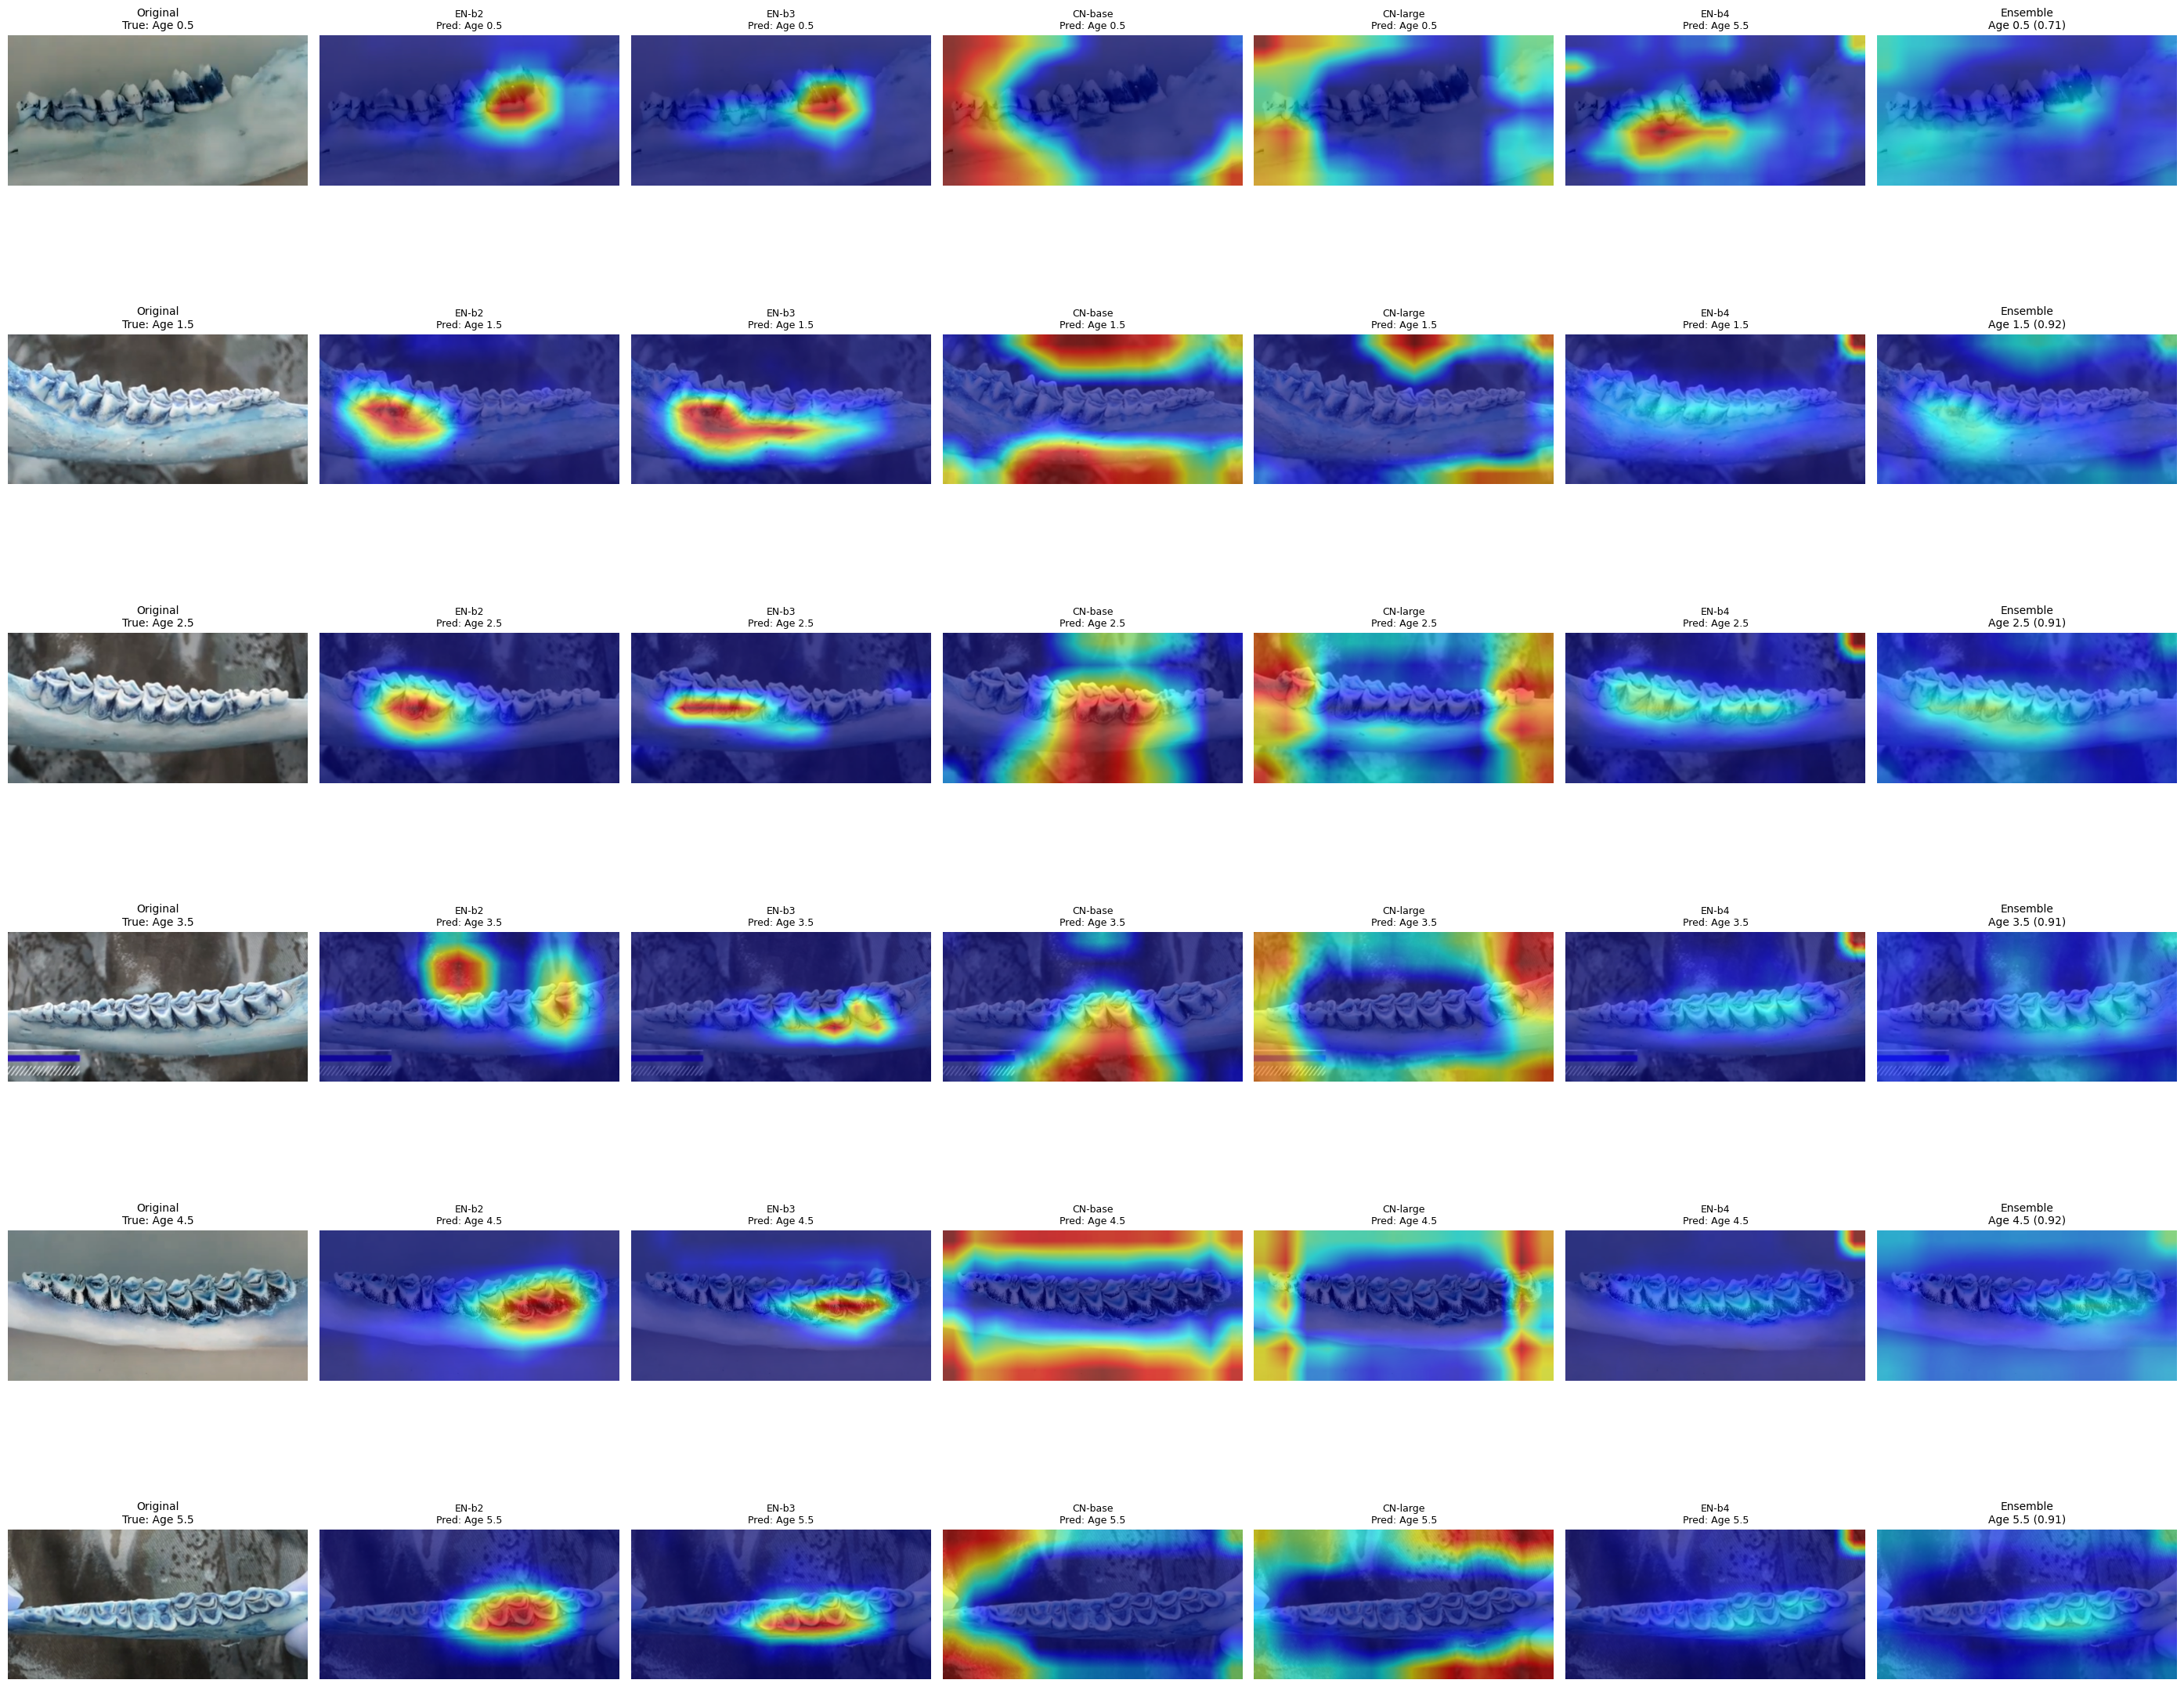

[SUCCESS] Ensemble attention comparison saved

Analyzing architecture differences for 4 samples...


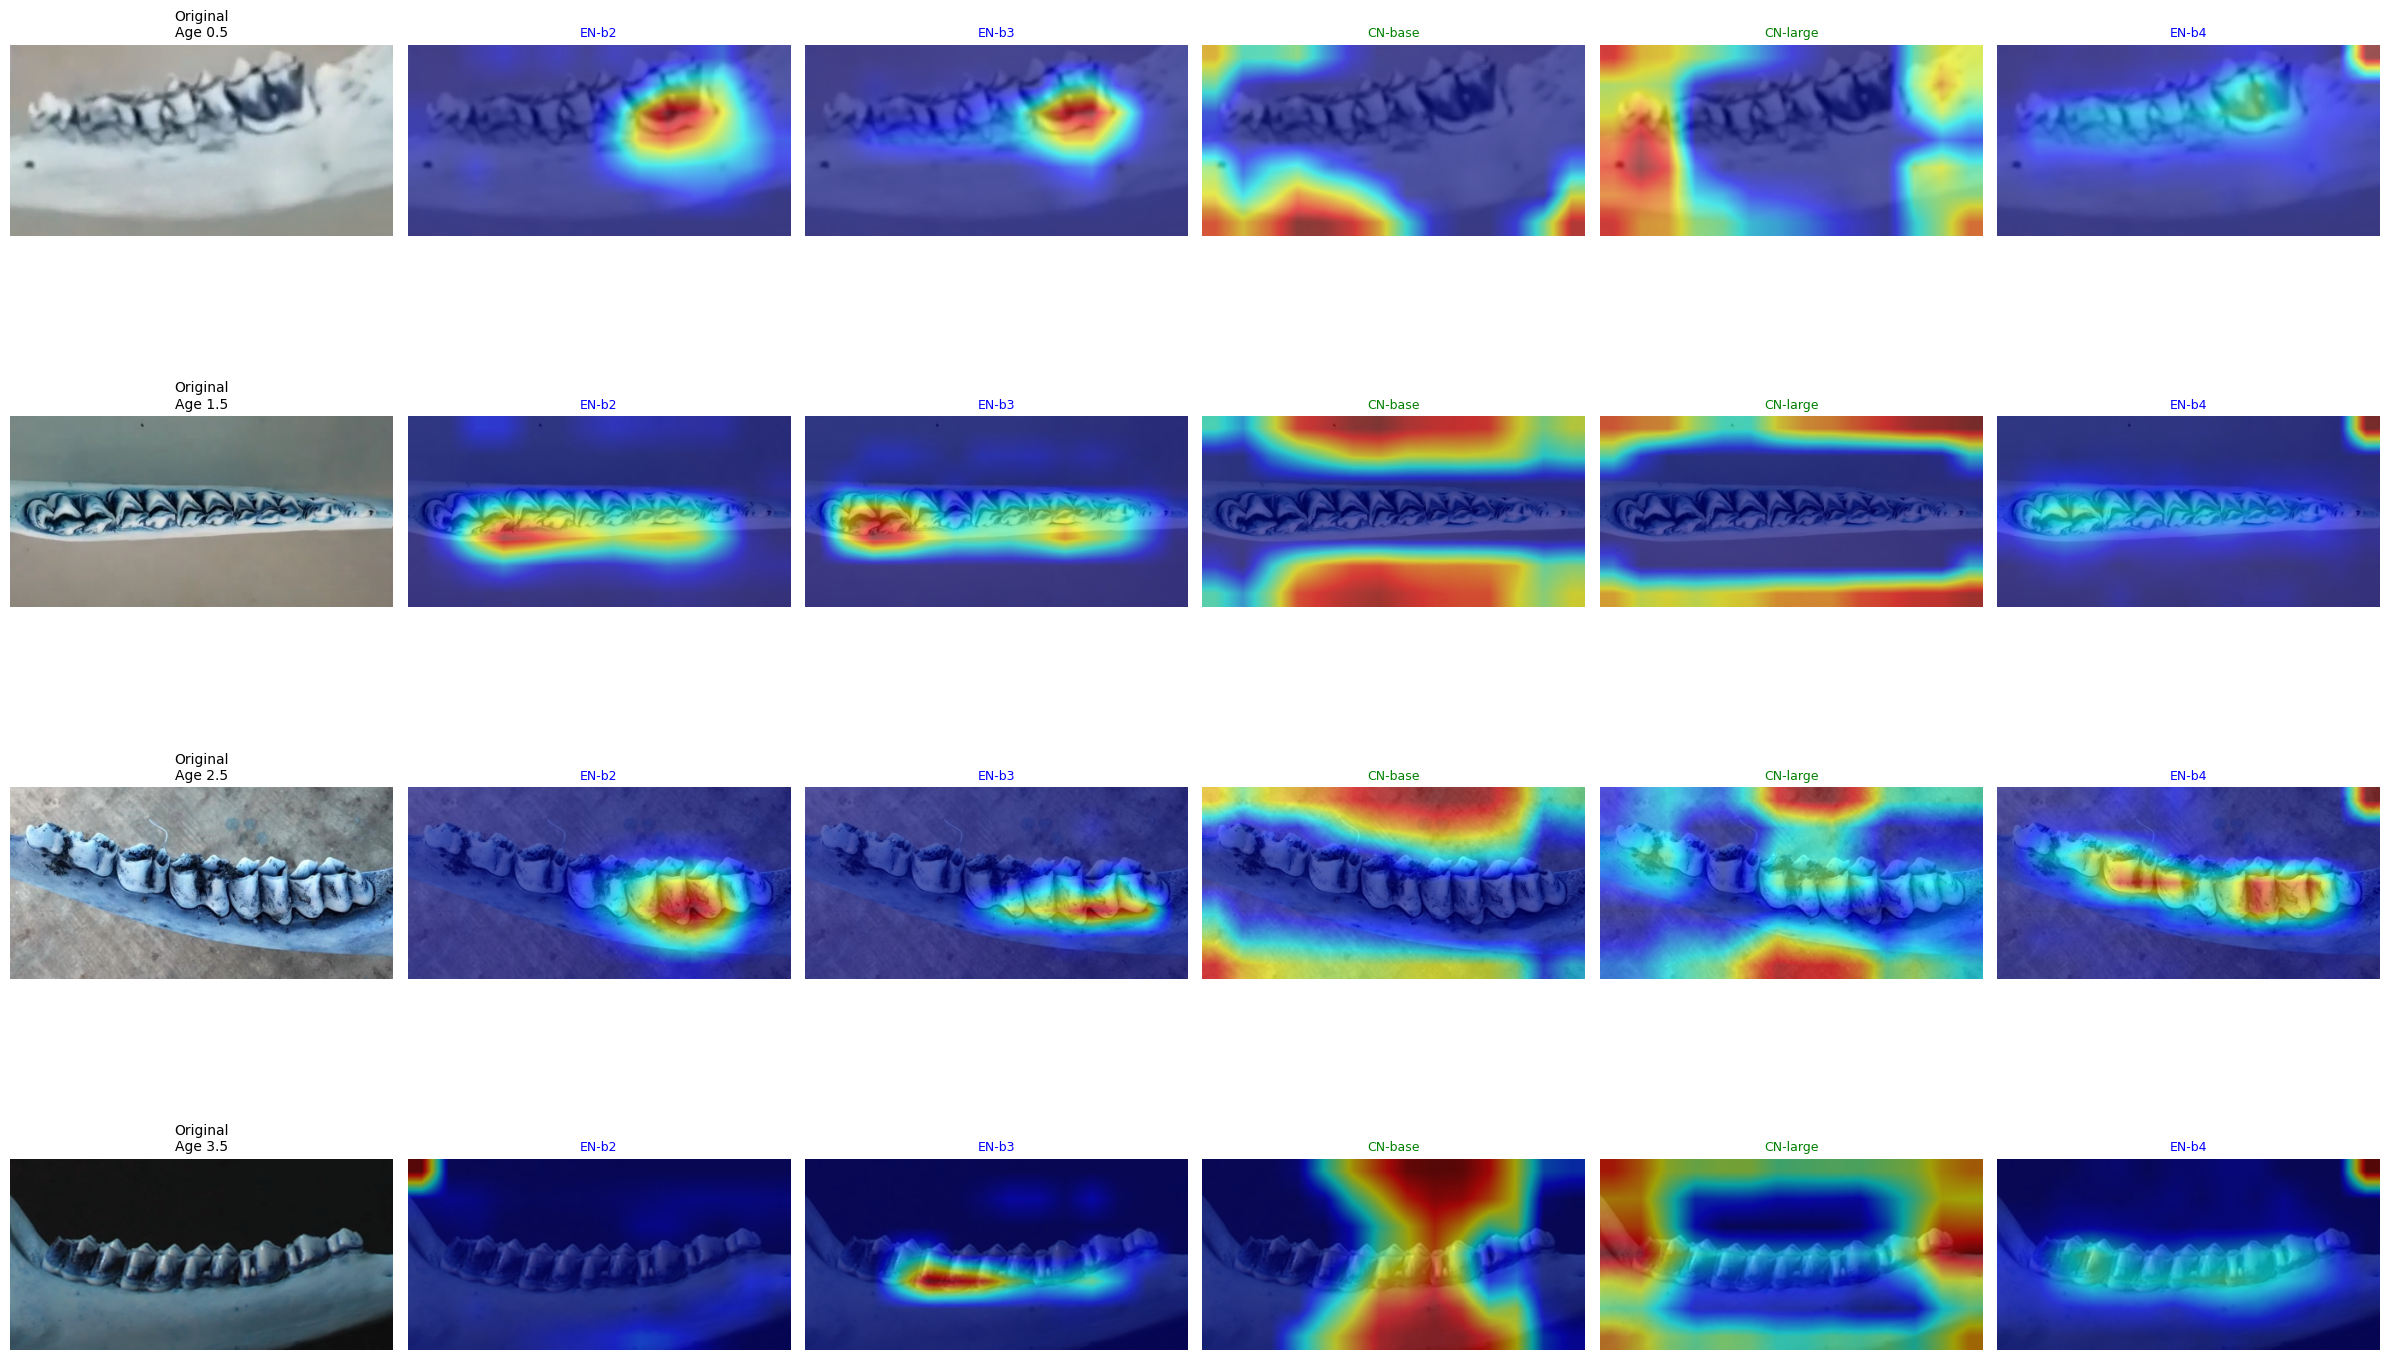

[SUCCESS] Architecture differences analysis saved

Generating attention statistics...


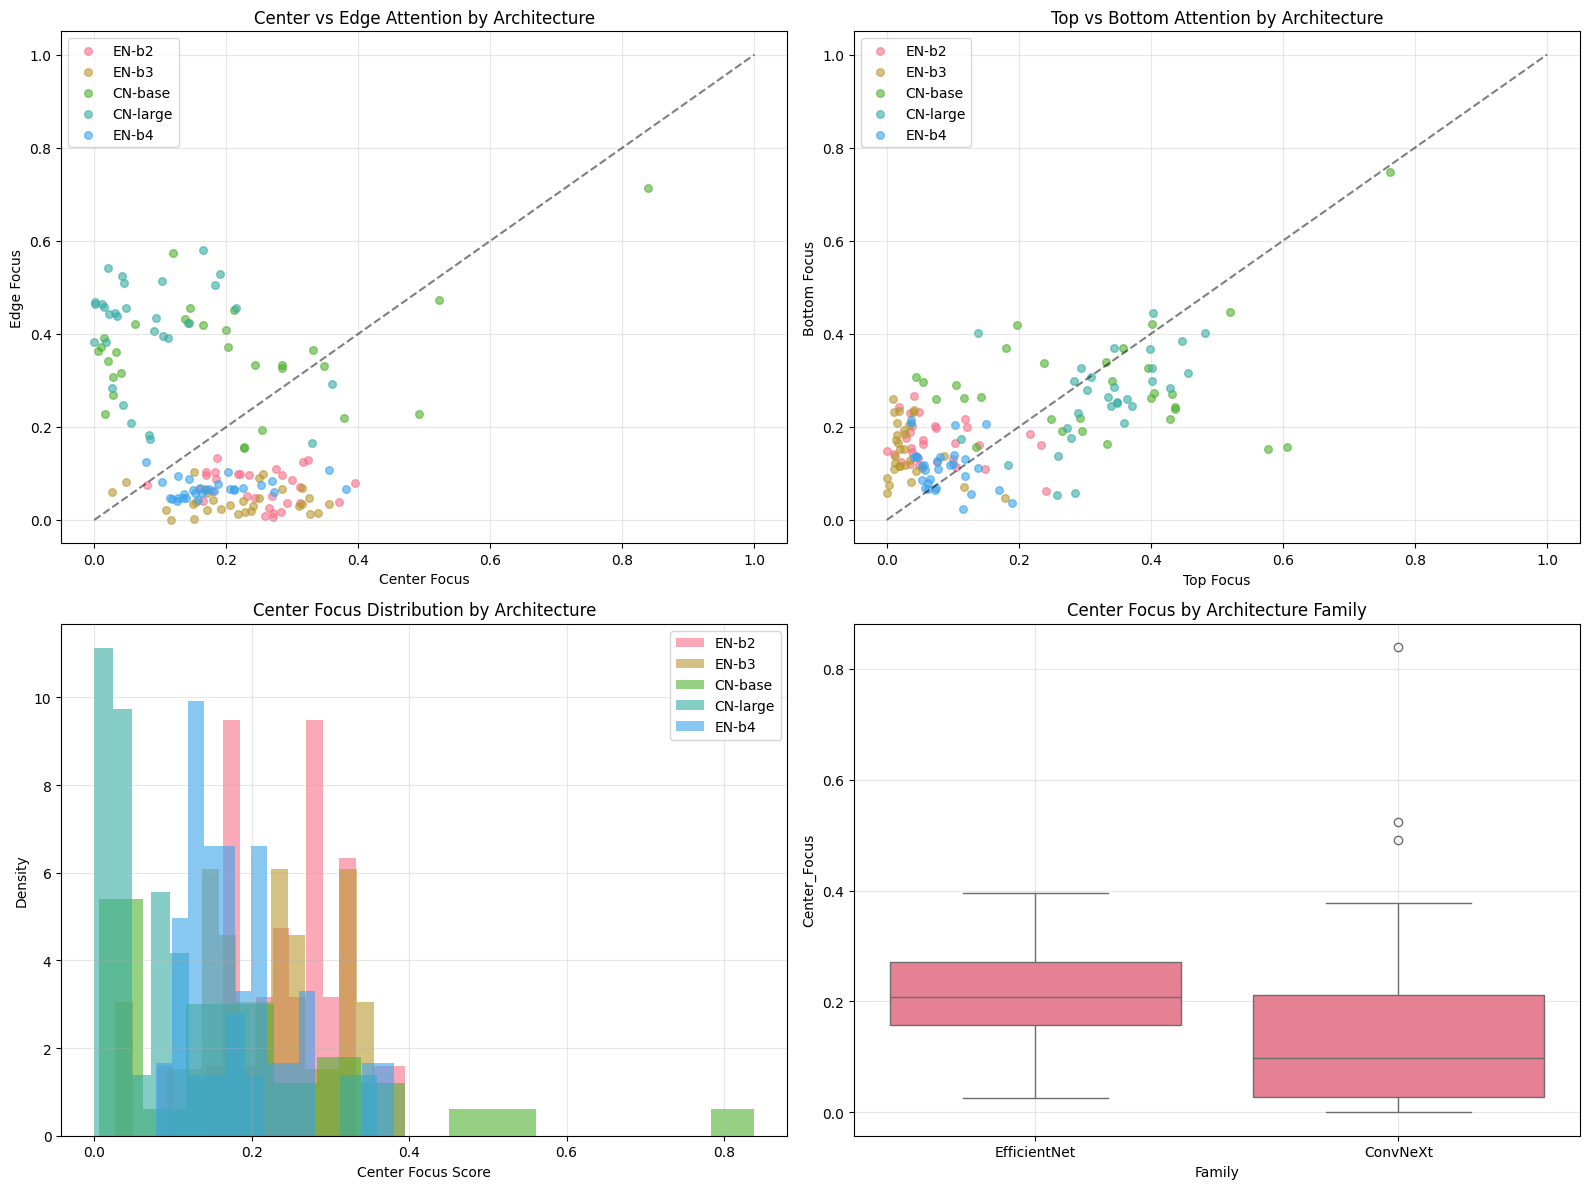


Attention Statistics Summary:
efficientnet_b2:
  Center focus: 0.247
  Edge focus: 0.070
  Center preference: +0.178
efficientnet_b3:
  Center focus: 0.216
  Edge focus: 0.042
  Center preference: +0.174
convnext_base:
  Center focus: 0.200
  Edge focus: 0.358
  Center preference: -0.157
convnext_large:
  Center focus: 0.089
  Edge focus: 0.405
  Center preference: -0.316
efficientnet_b4:
  Center focus: 0.181
  Edge focus: 0.068
  Center preference: +0.113

ENSEMBLE GRAD-CAM ANALYSIS COMPLETE!
Generated visualizations:
- ensemble_attention_comparison.png: Ensemble attention comparison
- architecture_attention_differences.png: Architecture-specific attention
- ensemble_attention_statistics.png: Statistical analysis

All files saved to 'ensemble_gradcam_visualizations/' directory

🎉 ENSEMBLE GRAD-CAM ANALYSIS COMPLETE!
🎉 Check 'ensemble_gradcam_visualizations/' for attention maps!
🎉 Analyzed 5 different architectures


In [16]:
# Ensemble Grad-CAM Feature Visualization Script for 448x224 Models
# Shows what regions different architectures focus on for deer age classification

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import os
import glob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class GradCAM:
    """Grad-CAM implementation for multiple CNN architectures"""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handles = []
        
        # Register hooks
        handle1 = self.target_layer.register_forward_hook(self.forward_hook)
        handle2 = self.target_layer.register_backward_hook(self.backward_hook)
        self.handles.extend([handle1, handle2])
    
    def forward_hook(self, module, input, output):
        """Save activations during forward pass"""
        self.activations = output.detach()
    
    def backward_hook(self, module, grad_input, grad_output):
        """Save gradients during backward pass"""
        self.gradients = grad_output[0].detach()
    
    def remove_hooks(self):
        """Remove hooks to free memory"""
        for handle in self.handles:
            handle.remove()
        self.handles = []
    
    def generate_cam(self, input_image, class_idx):
        """Generate Grad-CAM heatmap for specific class"""
        self.model.eval()
        
        # Ensure input is on correct device
        device = next(self.model.parameters()).device
        input_image = input_image.to(device)
        
        # Forward pass
        input_image.requires_grad_()
        output = self.model(input_image)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass for target class
        class_score = output[:, class_idx]
        class_score.backward()
        
        # Get gradients and activations
        if self.gradients is None or self.activations is None:
            print("Warning: No gradients or activations captured")
            return np.zeros((224, 448))
        
        gradients = self.gradients[0].to(device)  # Remove batch dimension
        activations = self.activations[0].to(device)  # Remove batch dimension
        
        # Calculate weights (global average pooling of gradients)
        weights = torch.mean(gradients, dim=(1, 2))
        
        # Generate CAM
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # Apply ReLU (only positive influences)
        cam = F.relu(cam)
        
        # Normalize
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.detach().cpu().numpy()

def get_target_layer(model, architecture):
    """Get the appropriate target layer for Grad-CAM based on architecture"""
    if 'efficientnet' in architecture:
        # For EfficientNet, use the last feature layer before global pooling
        if hasattr(model, 'conv_head'):
            return model.conv_head
        elif hasattr(model, 'blocks'):
            # Find the last block
            return model.blocks[-1].conv_pwl
        else:
            # Fallback to features if available
            if hasattr(model, 'features'):
                return model.features[-1]
    
    elif 'convnext' in architecture:
        # For ConvNeXt, use the last stage
        if hasattr(model, 'stages'):
            return model.stages[-1].blocks[-1].conv_dw
        elif hasattr(model, 'features'):
            return model.features[-1]
    
    # Generic fallback - try to find the last conv layer
    last_conv = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            last_conv = module
    
    if last_conv is not None:
        return last_conv
    else:
        raise ValueError(f"Could not find suitable target layer for {architecture}")

def load_original_data():
    """Load data using the same method as the training script"""
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        
        print(f"Processing {len(image_paths)} image files...")
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img_resized = cv2.resize(img, (448, 224))
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        from collections import Counter
        age_counts = Counter(ages_grouped)
        valid_ages = {age for age, count in age_counts.items() if count >= 3}
        
        filtered_images = []
        filtered_ages = []
        
        for img, age in zip(images, ages_grouped):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
        
        return np.array(filtered_images), filtered_ages
        
    except Exception as e:
        print(f"ERROR: {e}")
        raise

def create_model_from_checkpoint(checkpoint, device):
    """Recreate model from checkpoint with correct architecture"""
    architecture = checkpoint['model_architecture']
    num_classes = checkpoint['num_classes']
    
    arch_configs = {
        'efficientnet_b2': {'dropout': 0.25, 'classifier_attr': 'classifier'},
        'efficientnet_b3': {'dropout': 0.25, 'classifier_attr': 'classifier'},
        'efficientnet_b4': {'dropout': 0.3, 'classifier_attr': 'classifier'},
        'convnext_base': {'dropout': 0.4, 'classifier_attr': 'head'},
        'convnext_large': {'dropout': 0.4, 'classifier_attr': 'head'}
    }
    
    config = arch_configs.get(architecture, {'dropout': 0.3, 'classifier_attr': 'classifier'})
    
    try:
        model = timm.create_model(architecture, pretrained=True, num_classes=num_classes)
    except Exception as e:
        print(f"Failed to create {architecture}: {e}")
        return None
    
    # Recreate the exact same classifier structure as the original training
    classifier_attr = config['classifier_attr']
    
    if architecture.startswith('convnext'):
        if hasattr(model.head, 'fc'):
            in_features = model.head.fc.in_features
            model.head.fc = nn.Sequential(
                nn.Dropout(config['dropout']),
                nn.Linear(in_features, num_classes)
            )
        else:
            # For ConvNeXt models without fc in head
            model.eval()
            with torch.no_grad():
                test_input = torch.randn(1, 3, 224, 448).to(device)
                features = model.forward_features(test_input)
                in_features = features.shape[1]
            
            model.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Dropout(config['dropout']),
                nn.Linear(in_features, num_classes)
            )
    else:
        # For EfficientNet models
        if hasattr(model, classifier_attr):
            original_classifier = getattr(model, classifier_attr)
            
            if hasattr(original_classifier, 'in_features'):
                in_features = original_classifier.in_features
            else:
                # Find the last linear layer to get input features
                last_linear = None
                for module in original_classifier.modules():
                    if isinstance(module, nn.Linear):
                        last_linear = module
                if last_linear:
                    in_features = last_linear.in_features
                else:
                    print(f"Could not determine input features for {architecture}")
                    return None
            
            # Create the same Sequential structure as original training
            new_classifier = nn.Sequential(
                nn.Dropout(config['dropout']),
                nn.Linear(in_features, num_classes)
            )
            setattr(model, classifier_attr, new_classifier)
    
    # Now load the saved weights
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"   ✅ Loaded weights for {architecture}")
    except Exception as e:
        print(f"   ❌ Failed to load weights for {architecture}: {e}")
        return None
    
    return model.to(device)

class EnsembleGradCAMVisualizer:
    """Comprehensive Grad-CAM visualizer for ensemble models"""
    
    def __init__(self, ensemble_dir=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print("ENSEMBLE GRAD-CAM FEATURE VISUALIZER")
        print("="*60)
        print(f"Device: {self.device}")
        
        # Find ensemble directory if not provided
        if ensemble_dir is None:
            ensemble_dir = self.find_latest_ensemble_directory()
        
        self.ensemble_dir = ensemble_dir
        print(f"Loading from: {ensemble_dir}")
        
        # Load data and models
        self.load_data_and_models()
        
        # Create output directory
        Path("ensemble_gradcam_visualizations").mkdir(exist_ok=True)
        
        print("[SUCCESS] Ready for Grad-CAM visualization")
    
    def find_latest_ensemble_directory(self):
        """Find the most recent ensemble directory"""
        patterns = ["complete_ensemble_448x224_*", "practical_ensemble_448x224_*"]
        
        dirs = []
        for pattern in patterns:
            dirs.extend(glob.glob(pattern))
        
        if not dirs:
            raise FileNotFoundError("No ensemble directories found!")
        
        latest_dir = max(dirs, key=os.path.getmtime)
        return latest_dir
    
    def load_data_and_models(self):
        """Load all data and models"""
        print("\nLoading data...")
        
        # Load original data
        self.images, self.ages = load_original_data()
        
        # Create label mapping
        unique_ages = sorted(list(set(self.ages)))
        self.label_mapping = {age: i for i, age in enumerate(unique_ages)}
        self.unique_ages = unique_ages
        self.num_classes = len(unique_ages)
        self.class_names = [f'Age {age}' for age in unique_ages]
        
        # Convert ages to indices
        y_indices = np.array([self.label_mapping[age] for age in self.ages])
        
        # Create train/test split (same as training script)
        from sklearn.model_selection import train_test_split
        self.X_train_all, self.X_test, self.y_train_all, self.y_test = train_test_split(
            self.images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        print(f"Dataset loaded: {len(self.X_train_all)} train, {len(self.X_test)} test samples")
        print(f"Classes: {self.num_classes} age groups: {self.unique_ages}")
        
        # Load ensemble models
        self.load_ensemble_models()
    
    def load_ensemble_models(self):
        """Load all ensemble models"""
        print("\nLoading ensemble models...")
        
        # Try to load complete ensemble first
        ensemble_path = os.path.join(self.ensemble_dir, "complete_ensemble_448x224.pth")
        if os.path.exists(ensemble_path):
            print("Loading complete ensemble...")
            ensemble_data = torch.load(ensemble_path, map_location=self.device)
            
            self.architectures_used = ensemble_data['architectures_used']
            self.cv_scores = ensemble_data['cv_scores']
            
            # Load individual models
            self.models = []
            for i, arch in enumerate(self.architectures_used):
                # Create a mock checkpoint for model creation
                checkpoint = {
                    'model_architecture': arch,
                    'num_classes': self.num_classes,
                    'model_state_dict': ensemble_data['model_state_dicts'][i]
                }
                
                model = create_model_from_checkpoint(checkpoint, self.device)
                if model:
                    self.models.append(model)
                    print(f"   ✅ Loaded {arch}")
                else:
                    print(f"   ❌ Failed to load {arch}")
        
        else:
            # Load individual model files
            print("Loading individual model files...")
            self.models = []
            self.architectures_used = []
            self.cv_scores = []
            
            model_files = glob.glob(os.path.join(self.ensemble_dir, "model_*.pth"))
            model_files.sort()
            
            for model_path in model_files:
                checkpoint = torch.load(model_path, map_location=self.device)
                
                model = create_model_from_checkpoint(checkpoint, self.device)
                if model:
                    self.models.append(model)
                    self.architectures_used.append(checkpoint['model_architecture'])
                    self.cv_scores.append(checkpoint.get('cv_score', 0.0))
                    print(f"   ✅ Loaded {os.path.basename(model_path)}")
        
        print(f"[SUCCESS] Loaded {len(self.models)} models")
        print(f"Architectures: {self.architectures_used}")
    
    def preprocess_image(self, image):
        """Preprocess image for model input (448x224)"""
        if isinstance(image, np.ndarray):
            image = torch.FloatTensor(image)
        
        # Ensure correct format
        if image.max() > 1.0:
            image = image / 255.0
        
        # Convert to CHW if needed
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        # Ensure correct size (224, 448)
        if image.shape[-2:] != (224, 448):
            image = F.interpolate(image.unsqueeze(0), size=(224, 448), 
                                mode='bilinear', align_corners=False).squeeze(0)
        
        # Normalize using ImageNet stats
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = (image - mean) / std
        
        return image.unsqueeze(0).to(self.device)  # Add batch dimension
    
    def denormalize_image(self, tensor):
        """Convert normalized tensor back to displayable image"""
        # Remove batch dimension
        if len(tensor.shape) == 4:
            tensor = tensor.squeeze(0)
        
        # Denormalize
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean
        
        # Clamp to valid range
        tensor = torch.clamp(tensor, 0, 1)
        
        # Convert to numpy and transpose to HWC
        image = tensor.cpu().numpy().transpose(1, 2, 0)
        return image
    
    def overlay_heatmap(self, image, heatmap, alpha=0.6):
        """Overlay heatmap on original image"""
        # Resize heatmap to match image size
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        
        # Convert heatmap to colormap
        heatmap_colored = cv2.applyColorMap(
            (heatmap_resized * 255).astype(np.uint8), 
            cv2.COLORMAP_JET
        )
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        heatmap_colored = heatmap_colored.astype(np.float32) / 255.0
        
        # Ensure image is in correct format
        if image.max() <= 1.0:
            image_display = image
        else:
            image_display = image.astype(np.float32) / 255.0
        
        # Overlay
        overlaid = alpha * heatmap_colored + (1 - alpha) * image_display
        return overlaid
    
    def visualize_ensemble_attention(self, num_samples=6):
        """Create comprehensive ensemble attention visualization"""
        print(f"\nGenerating ensemble Grad-CAM visualizations for {num_samples} samples...")
        
        # Select diverse samples
        sample_indices = self.select_diverse_samples(num_samples)
        
        # Create figure: samples x (original + models + ensemble)
        num_cols = 2 + len(self.models)  # original + models + ensemble
        fig, axes = plt.subplots(num_samples, num_cols, figsize=(4*num_cols, 4*num_samples))
        
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        grad_cams = []
        
        # Initialize Grad-CAM for each model
        for i, model in enumerate(self.models):
            try:
                target_layer = get_target_layer(model, self.architectures_used[i])
                grad_cam = GradCAM(model, target_layer)
                grad_cams.append(grad_cam)
                print(f"   ✅ Grad-CAM ready for {self.architectures_used[i]}")
            except Exception as e:
                print(f"   ❌ Failed to setup Grad-CAM for {self.architectures_used[i]}: {e}")
                grad_cams.append(None)
        
        try:
            for sample_idx, idx in enumerate(sample_indices):
                print(f"   Processing sample {sample_idx + 1}/{num_samples}...")
                
                # Get image and true label
                original_image = self.X_test[idx]
                true_label = self.y_test[idx]
                true_age = self.unique_ages[true_label]
                
                # Preprocess for model
                input_tensor = self.preprocess_image(original_image.copy())
                
                # Display original image
                if original_image.max() > 1.0:
                    display_image = original_image.astype(np.float32) / 255.0
                else:
                    display_image = original_image.astype(np.float32)
                
                axes[sample_idx, 0].imshow(display_image)
                axes[sample_idx, 0].set_title(f'Original\nTrue: Age {true_age}', fontsize=10)
                axes[sample_idx, 0].axis('off')
                
                # Get ensemble prediction
                ensemble_probs = self.get_ensemble_prediction(input_tensor)
                ensemble_pred = np.argmax(ensemble_probs)
                ensemble_conf = ensemble_probs[ensemble_pred]
                predicted_age = self.unique_ages[ensemble_pred]
                
                # Generate Grad-CAM for each model
                model_heatmaps = []
                
                for model_idx, (model, grad_cam) in enumerate(zip(self.models, grad_cams)):
                    if grad_cam is None:
                        # Skip failed models
                        axes[sample_idx, model_idx + 1].text(0.5, 0.5, 'Failed', 
                                                           transform=axes[sample_idx, model_idx + 1].transAxes,
                                                           ha='center', va='center')
                        axes[sample_idx, model_idx + 1].axis('off')
                        model_heatmaps.append(None)
                        continue
                    
                    try:
                        # Get model prediction
                        with torch.no_grad():
                            model_output = model(input_tensor)
                            model_pred = torch.argmax(model_output, dim=1).item()
                        
                        # Generate heatmap for model's prediction
                        heatmap = grad_cam.generate_cam(input_tensor.clone(), model_pred)
                        model_heatmaps.append(heatmap)
                        
                        # Create overlay
                        overlaid = self.overlay_heatmap(display_image, heatmap)
                        
                        # Display
                        axes[sample_idx, model_idx + 1].imshow(overlaid)
                        arch_short = self.architectures_used[model_idx].replace('efficientnet_', 'EN-').replace('convnext_', 'CN-')
                        axes[sample_idx, model_idx + 1].set_title(f'{arch_short}\nPred: Age {self.unique_ages[model_pred]}', fontsize=9)
                        axes[sample_idx, model_idx + 1].axis('off')
                        
                    except Exception as e:
                        print(f"     ❌ Error processing {self.architectures_used[model_idx]}: {e}")
                        axes[sample_idx, model_idx + 1].text(0.5, 0.5, 'Error', 
                                                           transform=axes[sample_idx, model_idx + 1].transAxes,
                                                           ha='center', va='center')
                        axes[sample_idx, model_idx + 1].axis('off')
                        model_heatmaps.append(None)
                
                # Create ensemble heatmap (average of valid heatmaps)
                valid_heatmaps = [h for h in model_heatmaps if h is not None]
                if valid_heatmaps:
                    ensemble_heatmap = np.mean(valid_heatmaps, axis=0)
                    ensemble_overlaid = self.overlay_heatmap(display_image, ensemble_heatmap)
                    
                    axes[sample_idx, -1].imshow(ensemble_overlaid)
                    axes[sample_idx, -1].set_title(f'Ensemble\nAge {predicted_age} ({ensemble_conf:.2f})', fontsize=10)
                    axes[sample_idx, -1].axis('off')
                else:
                    axes[sample_idx, -1].text(0.5, 0.5, 'No Valid\nHeatmaps', 
                                            transform=axes[sample_idx, -1].transAxes,
                                            ha='center', va='center')
                    axes[sample_idx, -1].axis('off')
                
                # Clear GPU memory
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        finally:
            # Clean up all Grad-CAMs
            for grad_cam in grad_cams:
                if grad_cam is not None:
                    grad_cam.remove_hooks()
        
        plt.tight_layout()
        plt.savefig('ensemble_gradcam_visualizations/ensemble_attention_comparison.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        print("[SUCCESS] Ensemble attention comparison saved")
    
    def get_ensemble_prediction(self, input_tensor):
        """Get ensemble prediction probabilities"""
        # Use CV scores as weights
        scores_array = np.array(self.cv_scores[:len(self.models)])
        if len(scores_array) == 0 or np.sum(scores_array) == 0:
            weights = np.ones(len(self.models)) / len(self.models)
        else:
            weights = np.exp(scores_array / 20)
            weights = weights / weights.sum()
        
        ensemble_probs = np.zeros(self.num_classes)
        
        for i, model in enumerate(self.models):
            with torch.no_grad():
                outputs = model(input_tensor)
                probs = F.softmax(outputs, dim=1).cpu().numpy()[0]
                ensemble_probs += weights[i] * probs
        
        return ensemble_probs
    
    def analyze_architecture_differences(self, num_samples=4):
        """Analyze how different architectures focus on different regions"""
        print(f"\nAnalyzing architecture differences for {num_samples} samples...")
        
        # Group architectures by family
        arch_families = {}
        for i, arch in enumerate(self.architectures_used):
            if 'efficientnet' in arch:
                family = 'EfficientNet'
            elif 'convnext' in arch:
                family = 'ConvNeXt'
            else:
                family = 'Other'
            
            if family not in arch_families:
                arch_families[family] = []
            arch_families[family].append((i, arch))
        
        # Select samples
        sample_indices = self.select_diverse_samples(num_samples)
        
        fig, axes = plt.subplots(num_samples, len(self.models) + 1, figsize=(4*(len(self.models)+1), 4*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        grad_cams = []
        
        # Initialize Grad-CAM for each model
        for i, model in enumerate(self.models):
            try:
                target_layer = get_target_layer(model, self.architectures_used[i])
                grad_cam = GradCAM(model, target_layer)
                grad_cams.append(grad_cam)
            except Exception as e:
                print(f"   ❌ Failed to setup Grad-CAM for {self.architectures_used[i]}: {e}")
                grad_cams.append(None)
        
        try:
            for sample_idx, idx in enumerate(sample_indices):
                # Get image
                original_image = self.X_test[idx]
                true_label = self.y_test[idx]
                true_age = self.unique_ages[true_label]
                
                input_tensor = self.preprocess_image(original_image.copy())
                
                if original_image.max() > 1.0:
                    display_image = original_image.astype(np.float32) / 255.0
                else:
                    display_image = original_image.astype(np.float32)
                
                # Display original
                axes[sample_idx, 0].imshow(display_image)
                axes[sample_idx, 0].set_title(f'Original\nAge {true_age}', fontsize=10)
                axes[sample_idx, 0].axis('off')
                
                # Generate heatmaps for each architecture
                for model_idx, (model, grad_cam) in enumerate(zip(self.models, grad_cams)):
                    if grad_cam is None:
                        continue
                    
                    try:
                        # Use the true class for comparison
                        heatmap = grad_cam.generate_cam(input_tensor.clone(), true_label)
                        overlaid = self.overlay_heatmap(display_image, heatmap)
                        
                        axes[sample_idx, model_idx + 1].imshow(overlaid)
                        
                        # Color code by architecture family
                        arch = self.architectures_used[model_idx]
                        if 'efficientnet' in arch:
                            color = 'blue'
                            family = 'EN'
                        elif 'convnext' in arch:
                            color = 'green'
                            family = 'CN'
                        else:
                            color = 'red'
                            family = 'Other'
                        
                        arch_short = arch.replace('efficientnet_', 'EN-').replace('convnext_', 'CN-')
                        axes[sample_idx, model_idx + 1].set_title(f'{arch_short}', fontsize=9, color=color)
                        axes[sample_idx, model_idx + 1].axis('off')
                        
                    except Exception as e:
                        print(f"     Error processing {arch}: {e}")
        
        finally:
            # Clean up
            for grad_cam in grad_cams:
                if grad_cam is not None:
                    grad_cam.remove_hooks()
        
        plt.tight_layout()
        plt.savefig('ensemble_gradcam_visualizations/architecture_attention_differences.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        print("[SUCCESS] Architecture differences analysis saved")
    
    def create_attention_statistics(self):
        """Generate attention statistics for each architecture"""
        print("\nGenerating attention statistics...")
        
        attention_stats = {}
        for arch in self.architectures_used:
            attention_stats[arch] = {
                'center_focus': [],
                'edge_focus': [],
                'top_focus': [],
                'bottom_focus': []
            }
        
        grad_cams = []
        
        # Initialize Grad-CAM for each model
        for i, model in enumerate(self.models):
            try:
                target_layer = get_target_layer(model, self.architectures_used[i])
                grad_cam = GradCAM(model, target_layer)
                grad_cams.append(grad_cam)
            except Exception as e:
                grad_cams.append(None)
        
        try:
            # Analyze attention patterns for subset of test images
            for i in range(min(30, len(self.X_test))):
                try:
                    input_tensor = self.preprocess_image(self.X_test[i])
                    
                    for model_idx, (model, grad_cam) in enumerate(zip(self.models, grad_cams)):
                        if grad_cam is None:
                            continue
                        
                        # Get prediction
                        with torch.no_grad():
                            output = model(input_tensor)
                            predicted_class = torch.argmax(output, dim=1).item()
                        
                        # Generate heatmap
                        heatmap = grad_cam.generate_cam(input_tensor.clone(), predicted_class)
                        
                        # Analyze attention regions
                        h, w = heatmap.shape
                        
                        # Center vs edges
                        center_region = heatmap[h//4:3*h//4, w//4:3*w//4]
                        edge_regions = np.concatenate([
                            heatmap[:h//4, :].flatten(),
                            heatmap[3*h//4:, :].flatten(),
                            heatmap[:, :w//4].flatten(),
                            heatmap[:, 3*w//4:].flatten()
                        ])
                        
                        arch = self.architectures_used[model_idx]
                        attention_stats[arch]['center_focus'].append(np.mean(center_region))
                        attention_stats[arch]['edge_focus'].append(np.mean(edge_regions))
                        
                        # Top vs bottom
                        top_region = heatmap[:h//2, :]
                        bottom_region = heatmap[h//2:, :]
                        
                        attention_stats[arch]['top_focus'].append(np.mean(top_region))
                        attention_stats[arch]['bottom_focus'].append(np.mean(bottom_region))
                    
                    # Clear GPU memory
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                        
                except Exception as e:
                    print(f"   Error processing image {i}: {e}")
                    continue
        
        finally:
            # Clean up
            for grad_cam in grad_cams:
                if grad_cam is not None:
                    grad_cam.remove_hooks()
        
        # Create comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Center vs Edge focus by architecture
        for arch in self.architectures_used:
            if attention_stats[arch]['center_focus']:
                center_vals = attention_stats[arch]['center_focus']
                edge_vals = attention_stats[arch]['edge_focus']
                
                arch_short = arch.replace('efficientnet_', 'EN-').replace('convnext_', 'CN-')
                axes[0, 0].scatter(center_vals, edge_vals, alpha=0.6, label=arch_short, s=30)
        
        axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[0, 0].set_xlabel('Center Focus')
        axes[0, 0].set_ylabel('Edge Focus')
        axes[0, 0].set_title('Center vs Edge Attention by Architecture')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Top vs Bottom focus by architecture
        for arch in self.architectures_used:
            if attention_stats[arch]['top_focus']:
                top_vals = attention_stats[arch]['top_focus']
                bottom_vals = attention_stats[arch]['bottom_focus']
                
                arch_short = arch.replace('efficientnet_', 'EN-').replace('convnext_', 'CN-')
                axes[0, 1].scatter(top_vals, bottom_vals, alpha=0.6, label=arch_short, s=30)
        
        axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[0, 1].set_xlabel('Top Focus')
        axes[0, 1].set_ylabel('Bottom Focus')
        axes[0, 1].set_title('Top vs Bottom Attention by Architecture')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Center focus distribution
        for arch in self.architectures_used:
            if attention_stats[arch]['center_focus']:
                arch_short = arch.replace('efficientnet_', 'EN-').replace('convnext_', 'CN-')
                axes[1, 0].hist(attention_stats[arch]['center_focus'], alpha=0.6, 
                              label=arch_short, bins=15, density=True)
        
        axes[1, 0].set_xlabel('Center Focus Score')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('Center Focus Distribution by Architecture')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Architecture family comparison
        family_stats = {'EfficientNet': [], 'ConvNeXt': []}
        for arch in self.architectures_used:
            if attention_stats[arch]['center_focus']:
                if 'efficientnet' in arch:
                    family_stats['EfficientNet'].extend(attention_stats[arch]['center_focus'])
                elif 'convnext' in arch:
                    family_stats['ConvNeXt'].extend(attention_stats[arch]['center_focus'])
        
        families = []
        center_scores = []
        for family, scores in family_stats.items():
            if scores:
                families.extend([family] * len(scores))
                center_scores.extend(scores)
        
        if families:
            import pandas as pd
            import seaborn as sns
            
            df = pd.DataFrame({'Family': families, 'Center_Focus': center_scores})
            sns.boxplot(data=df, x='Family', y='Center_Focus', ax=axes[1, 1])
            axes[1, 1].set_title('Center Focus by Architecture Family')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('ensemble_gradcam_visualizations/ensemble_attention_statistics.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print summary
        print("\nAttention Statistics Summary:")
        for arch in self.architectures_used:
            if attention_stats[arch]['center_focus']:
                center_mean = np.mean(attention_stats[arch]['center_focus'])
                edge_mean = np.mean(attention_stats[arch]['edge_focus'])
                print(f"{arch}:")
                print(f"  Center focus: {center_mean:.3f}")
                print(f"  Edge focus: {edge_mean:.3f}")
                print(f"  Center preference: {center_mean - edge_mean:+.3f}")
        
        return attention_stats
    
    def select_diverse_samples(self, num_samples):
        """Select diverse samples for visualization"""
        # Get ensemble predictions for diversity
        selected_indices = []
        
        # Try to get samples from each class
        for class_idx in range(self.num_classes):
            class_indices = np.where(np.array(self.y_test) == class_idx)[0]
            if len(class_indices) > 0:
                selected_indices.append(np.random.choice(class_indices))
        
        # Fill remaining with random samples
        remaining_needed = num_samples - len(selected_indices)
        if remaining_needed > 0:
            available_indices = [i for i in range(len(self.y_test)) if i not in selected_indices]
            additional = np.random.choice(available_indices, 
                                        min(remaining_needed, len(available_indices)), 
                                        replace=False)
            selected_indices.extend(additional)
        
        return selected_indices[:num_samples]
    
    def run_complete_gradcam_analysis(self):
        """Run complete Grad-CAM analysis"""
        print("\nSTARTING COMPLETE ENSEMBLE GRAD-CAM ANALYSIS")
        print("="*60)
        
        try:
            # 1. Ensemble attention visualization
            self.visualize_ensemble_attention(num_samples=6)
            
            # 2. Architecture differences analysis
            self.analyze_architecture_differences(num_samples=4)
            
            # 3. Attention statistics
            stats = self.create_attention_statistics()
            
            print("\n" + "="*60)
            print("ENSEMBLE GRAD-CAM ANALYSIS COMPLETE!")
            print("="*60)
            print("Generated visualizations:")
            print("- ensemble_attention_comparison.png: Ensemble attention comparison")
            print("- architecture_attention_differences.png: Architecture-specific attention")
            print("- ensemble_attention_statistics.png: Statistical analysis")
            print("\nAll files saved to 'ensemble_gradcam_visualizations/' directory")
            
            return stats
            
        except Exception as e:
            print(f"Error in Grad-CAM analysis: {e}")
            import traceback
            traceback.print_exc()

def run_ensemble_gradcam_analysis(ensemble_dir=None):
    """Main function to run ensemble Grad-CAM analysis"""
    print("ENSEMBLE GRAD-CAM FEATURE VISUALIZATION")
    print("="*60)
    
    try:
        # Initialize visualizer
        visualizer = EnsembleGradCAMVisualizer(ensemble_dir)
        
        # Run complete analysis
        stats = visualizer.run_complete_gradcam_analysis()
        
        return visualizer, stats
        
    except Exception as e:
        print(f"Grad-CAM analysis failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Usage
if __name__ == "__main__":
    # Run analysis on the latest ensemble directory
    # Or specify: run_ensemble_gradcam_analysis("complete_ensemble_448x224_20250716_123456")
    
    visualizer, stats = run_ensemble_gradcam_analysis()
    
    if visualizer is not None:
        print("\n🎉 ENSEMBLE GRAD-CAM ANALYSIS COMPLETE!")
        print("🎉 Check 'ensemble_gradcam_visualizations/' for attention maps!")
        print(f"🎉 Analyzed {len(visualizer.models)} different architectures")
    else:
        print("\n❌ Analysis failed. Check error messages above.")